In [4]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [36]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score

In [748]:
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

In [841]:
class SquareScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square scale.
    """
 
    name = 'square'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**2
 
        def inverted(self):
            return SquareScale.InvertedSquareTransform()
 
    class InvertedSquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)
 
        def inverted(self):
            return SquareScale.SquareTransform()
 
    def get_transform(self):
        return self.SquareTransform()

mscale.register_scale(SquareScale)

In [6]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [1080]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [8]:
sample = "Sample_N705_-_ER1"
new_sample_name = "MCF7-labo-er1"
quant_params_ds = "downsampled-raw-reads/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "er1"

In [9]:
def hammingDist(str1, str2, fillchar = '-'):
    return sum([ch1 != ch2 for (ch1,ch2) in itertools.zip_longest(str1, str2, fillvalue = fillchar)])

In [10]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]

In [11]:
def plot_errors_v1(connected_components, barcodes, weight_by_lib = True) :
    
    fig, ax = plt.subplots(figsize = (3.5,2.5))

    ind = np.arange(12) 
    error_pos = [{"A": 0, "T": 0, "G": 0, "C": 0} for _ in ind]

        
    for component in connected_components :
        
        if len(component) > 1 :
            
            n_reads = sc.obs[[(barcode in component) and (barcode in barcodes) for barcode in sc.obs_names]]["raw_cb_freq"].values
            nucleotides_per_position = np.array([list(c) for c in np.intersect1d(component, barcodes)]).T

            for i, (nts_pos,r) in enumerate(zip(nucleotides_per_position, np.repeat([n_reads], 12, axis=0))) :
                if len(np.unique(nts_pos)) > 1 :
                    for nt in error_pos[i].keys() :
                        if weight_by_lib :
                            error_pos[i][nt] += np.sum(r[nts_pos == nt])
                        else :
                            error_pos[i][nt] += 1

    
    
    counts = np.array([list(error_pos[i].values()) for i in ind])

    width = 0.35
    bottom = 0
    for c in np.array(counts).T :
        ax.bar(ind, c, width = 0.25, bottom = bottom)
        bottom += c

    ax.legend(labels = error_pos[0].keys())
    plt.xticks(ind, labels = ind+1)
    plt.show()

In [12]:
def plot_errors(errors_dict, barcodes, weight_by_lib = True) :
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}-{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


    for barcode1 in errors_dict.keys() :
        for barcode2 in errors_dict[barcode1] :
            if barcode2 not in barcodes :
                continue
            pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
            nt1 = list(barcode1)[pos]
            nt2 = list(barcode2)[pos]
            if weight_by_lib :
                substitutions[f"{pos+1}-{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
            else :
                substitutions[f"{pos+1}-{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.tight_layout()

In [13]:
def get_intended_barcodes(errors_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in errors_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

In [14]:
def get_whitelist_v1(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    # n_components, labels = connected_components(csgraph = csr_matrix(neighbors_mtx), directed=False, return_labels=True)
    
    for component in all_components :
    #for component_idx in range(n_components) :
        
        #component = barcodes[labels == component_idx]
        
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            absorbed = set([])        
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_barcodes = sorting_df.sort_values(by=["total_neighbors", "total_UMIs"], ascending=False).index.values

            for barcode in sorted_barcodes :
                neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
                whitelist.append(barcode)
                error_dict[barcode] = list(neighbors[[n not in absorbed for n in neighbors]])
                absorbed.add(barcode)
                absorbed.update(list(neighbors))
                if len(absorbed) == len(component) :
                    break
    
    return all_components, error_dict, whitelist

In [930]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_comp = sorting_df.sort_values(by=["total_UMIs"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
#             neighbors = neighbors_mtx.loc[barcode][sorted_comp]
#             neighbors = neighbors.index.values[neighbors == 1]
#             error_dict[barcode] = neighbors
            error_dict[barcode] = sorted_comp[1:]

    
    return all_components, error_dict, whitelist

### Plotting parameters

In [16]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [17]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])

sc.obs_names = sc.obs["CB"]

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [18]:
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())

# libs = sc.obs["total_UMIs"].values * 0.8
# scanpy.pp.downsample_counts(adata=sc, counts_per_cell=libs)

In [835]:
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


In [118]:
sc.X.shape

(3000, 20305)

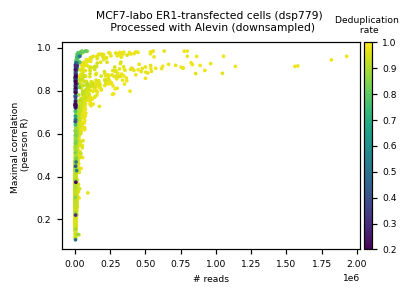

In [1024]:
fig, _ = plt.subplots(figsize=(3.5,2.5))
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo ER1-transfected cells (dsp779) \n Processed with Alevin (downsampled)",\
                        color_title = "Deduplication \n rate", save = f"./figs/{cond}-reads-max-corr-downsampled.svg", \
                        vmax=1, vmin=0.2, fig=fig, order_color = 'descending')


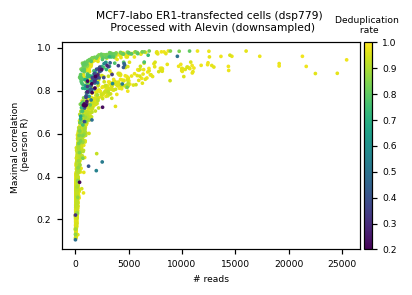

In [1027]:
fig, _ = plt.subplots(figsize=(3.5,2.5))
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo ER1-transfected cells (dsp779) \n Processed with Alevin (downsampled)",\
                        color_title = "Deduplication \n rate", save = f"./figs/{cond}-reads-max-corr-downsampled.svg", \
                        vmax=1, vmin=0.2, fig=fig, order_color = 'descending')

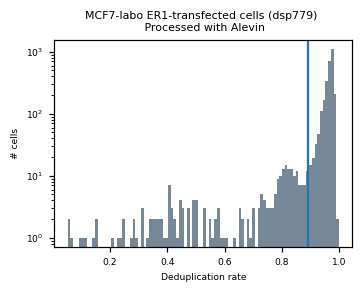

In [844]:
plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"], bins = 100, color = "lightslategray");
plt.xlabel("Deduplication rate");
plt.ylabel("# cells");
plt.axvline(x=0.89)
plt.title("MCF7-labo ER1-transfected cells (dsp779) \n Processed with Alevin")
plt.savefig(f"./figs/distrib_dedup_{cond}.svg")
plt.yscale('log')

In [1535]:
gm = GaussianMixture(3)
clusters_3 = gm.fit_predict(sc.obs["DedupRate"].values.reshape(-1,1)).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_3[clusters_3 == cl] = str(new_cl)

sc.obs["cluster_3"] = clusters_3

# s3 = silhouette_score(sc.obs["DedupRate"].values.reshape(-1, 1), sc.obs["cluster_3"].values)
# print(s3)

In [1381]:
barcodes = sc.obs_names
n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]

sizes_dict = {}
n = np.unique(n_neighbors)
n.sort()
s = []
si = 50
for ni in n :
    sizes_dict[ni] = si
    si += 5
    
sizes = np.array([sizes_dict[ni] for ni in n_neighbors])

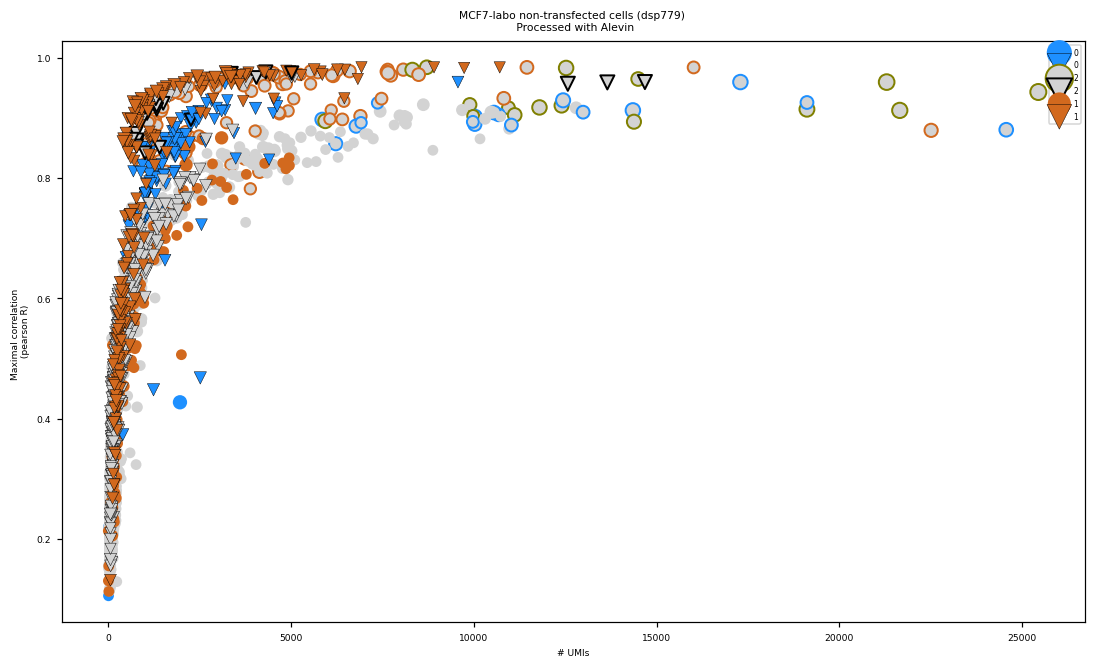

In [1537]:
fig, _ = plt.subplots(figsize=(12,7))


# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1


# originals_max_low = []
# originals_max_mid = []
# errors = np.concatenate(list(errors_dict.values()))
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if barcode1 in errors_low_dedup :
#                 originals_max_low.append(barcode2)
#             elif barcode1 in errors_mid_dedup :
#                 originals_max_mid.append(barcode2)               
                
# unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
# unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
# for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
#     x = sc.obs["max_corr"].loc[errors_dict[barcode]]
#     idx = x.values.argmax()
#     max_barcode = x.index[idx]
#     if max_barcode in errors_low_dedup :
#         unique_originals_max_low.append(barcode)
#     elif max_barcode in errors_mid_dedup :
#         unique_originals_max_mid.append(barcode)

# sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
# sizes = ((np.array(n_neighbors)+1)**(2/(np.array(n_neighbors)+1)))*100
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([originals_mid_dedup, originals_low_dedup]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in np.setdiff1d(originals_mid_dedup, originals_low_dedup) else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in np.setdiff1d(originals_low_dedup, originals_mid_dedup) else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["olive" if barcode in np.intersect1d(originals_low_dedup, originals_mid_dedup) else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])
        

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["cluster_3"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'0' : "dodgerblue", '1' : "chocolate", '2':"lightgray"},
                        order_color= ['0','2','1'], marker=markers,  order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

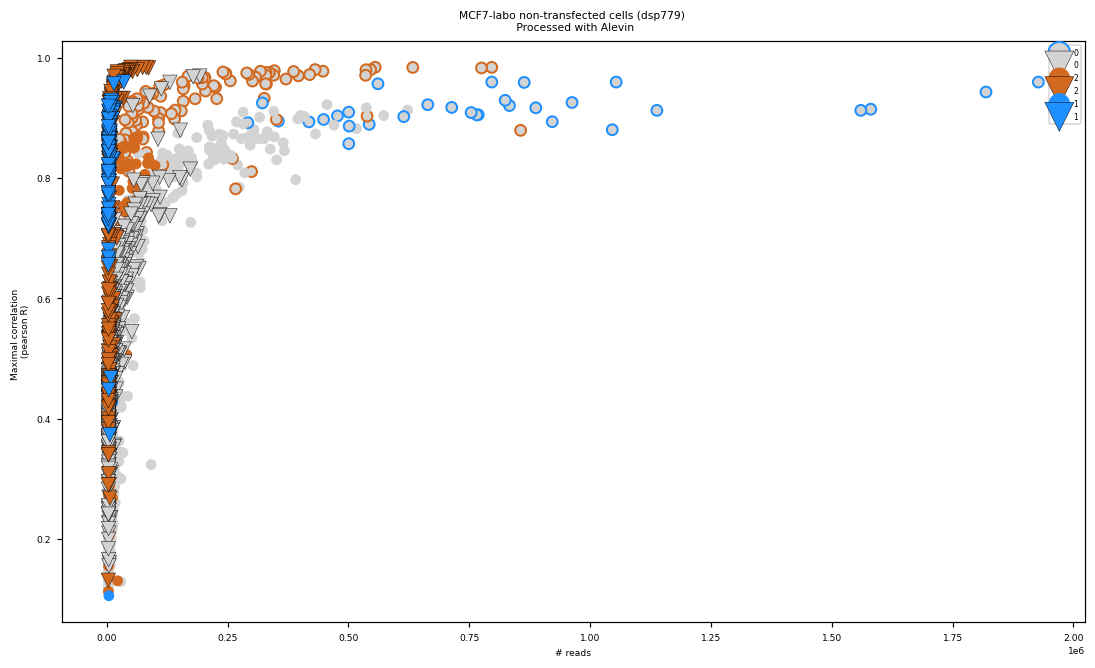

In [1291]:
fig, _ = plt.subplots(figsize=(12,7))


i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)

# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1



originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])

              
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["cluster_3"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'1' : "dodgerblue", '2' : "chocolate", '0':"lightgray"},
                        order_color= ['0','2','1'], marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

In [1293]:
np.intersect1d(originals_max_low, originals_max_mid)

array([], dtype='<U12')

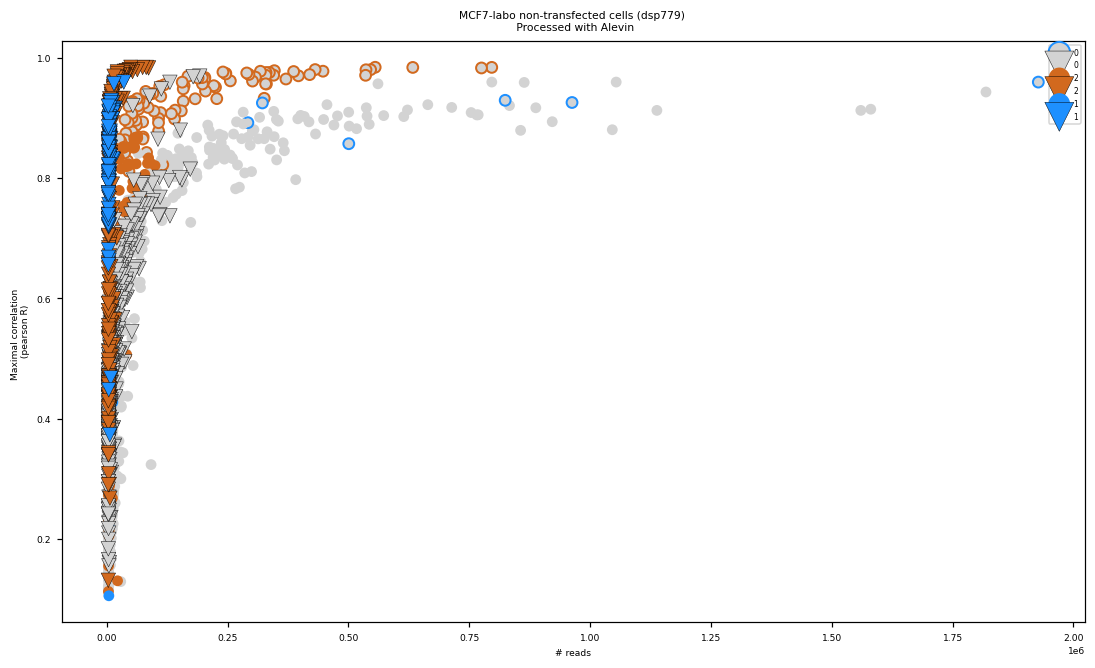

In [1292]:
fig, _ = plt.subplots(figsize=(12,7))


i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)

# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1



originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 and barcodes_corr_max.loc[barcode2][0] == barcode1:
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])

              
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["cluster_3"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'1' : "dodgerblue", '2' : "chocolate", '0':"lightgray"},
                        order_color= ['0','2','1'], marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

In [419]:
sc.obs["first_pos"] = np.array([barcode[0] for barcode in sc.obs_names])

gm = KMeans(3)
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
clusters_3 = gm.fit_predict(np.array([sc.obs["DedupRate"].loc[errors], sc.obs["AT"].loc[errors]]).T).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_3[clusters_3 == cl] = str(new_cl)

# sc.obs["cluster_3"] = clusters_3

sc.obs["cluster_3"] = np.repeat("no error", sc.X.shape[0])
sc.obs["AT"] = np.repeat(False, sc.X.shape[0])
for barcode, cl in zip(errors, clusters_3) :
    sc.obs["cluster_3"].loc[barcode] = cl
    if barcode[0] == "T" and get_intended_barcodes(errors_dict, [barcode])[0][0][0] == "A" :
        sc.obs["AT"].loc[barcode] = True
#     sc.obs["cluster_3"].iloc._setitem_with_indexer(np.argwhere(sc.obs_names.values == barcode)[0], cl)

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [597]:
gm = KMeans(2)
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
clusters = gm.fit_predict(np.array([sc.obs["DedupRate"].loc[errors], sc.obs["max_corr"].loc[errors]/np.log1p(sc.obs["total_UMIs"].loc[errors])]).T).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
# sc.obs["cluster_3"] = clusters_3
sc.obs["clusters"] = np.repeat("0", sc.X.shape[0])
# sc.obs["AT"] = np.repeat(False, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)
#     if barcode[0] == "T" and get_intended_barcodes(errors_dict, [barcode])[0][0][0] == "A" :
#         sc.obs["AT"].loc[barcode] = True
#     sc.obs["cluster_3"].iloc._setitem_with_indexer(np.argwhere(sc.obs_names.values == barcode)[0], cl)


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
fig, _ = plt.subplots(figsize=(12,7))

i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)


# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1


originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])
        

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 70, color = sc.obs["AT"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'A>T' : "dodgerblue", "no error" : "lightgray"},
                        order_color= ['no error','A>T'], marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

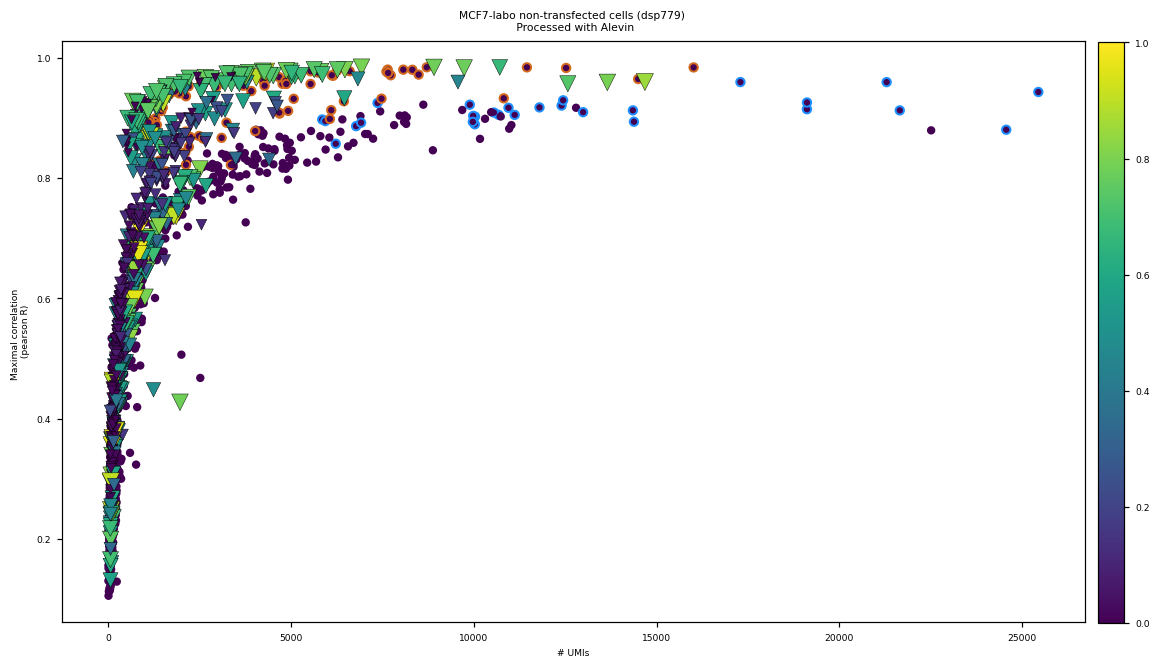

In [490]:
fig, _ = plt.subplots(figsize=(12,7))

i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)


# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1


originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])

errors = np.concatenate(list(errors_dict.values()))
sizes = np.array([30 if cb not in errors else 40 + (sc.obs["total_UMIs"].loc[cb] / sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, [cb])[0][0]])*100 for cb in sc.obs_names])
c = np.array([0 if cb not in errors else sc.obs["total_UMIs"].loc[cb] / sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, [cb])[0][0]] for cb in sc.obs_names])

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = sizes, color = c,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'0' : "dodgerblue", '1' : "chocolate", '2':"lightgray", "no error" : "lightgray"},
                        order_color= ['no error','2','0','1'], marker=markers, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

In [519]:
sc.obs["total_UMIs"].values[(sc.obs["clusters"] == "0") & ([cb in whitelist for cb in sc.obs_names])]

array([4.948e+03, 3.239e+03, 3.073e+03, 2.179e+03, 2.000e+03, 1.866e+03,
       2.121e+03, 4.860e+03, 1.561e+03, 1.517e+03, 2.055e+03, 1.360e+03,
       3.000e+00, 1.104e+03, 1.168e+03, 1.130e+03, 1.028e+03, 1.251e+03,
       9.700e+02, 1.033e+03, 9.100e+02, 8.150e+02, 9.540e+02, 7.290e+02,
       8.200e+02, 9.540e+02, 7.370e+02, 6.600e+02, 5.860e+02, 8.040e+02,
       8.400e+02, 7.460e+02, 6.980e+02, 8.310e+02, 5.760e+02, 8.850e+02,
       6.360e+02, 5.570e+02, 5.000e+02, 7.010e+02, 4.520e+02, 6.180e+02,
       6.230e+02, 2.517e+03, 3.620e+02, 4.590e+02, 7.080e+02, 3.780e+02,
       7.020e+02, 4.060e+02, 7.300e+02, 1.420e+02, 4.220e+02, 2.290e+02,
       3.040e+02, 4.870e+02, 1.770e+02, 1.272e+03, 9.000e+00, 6.700e+01,
       1.390e+03, 1.510e+02, 2.790e+02, 2.560e+02, 1.230e+02, 6.000e+00,
       2.370e+02, 2.360e+02, 1.010e+02, 2.560e+02, 1.420e+02, 5.440e+02,
       2.520e+02, 3.920e+02, 1.840e+02, 3.080e+02, 2.810e+02, 1.400e+01,
       2.070e+02, 1.260e+02, 2.080e+02, 2.170e+02, 

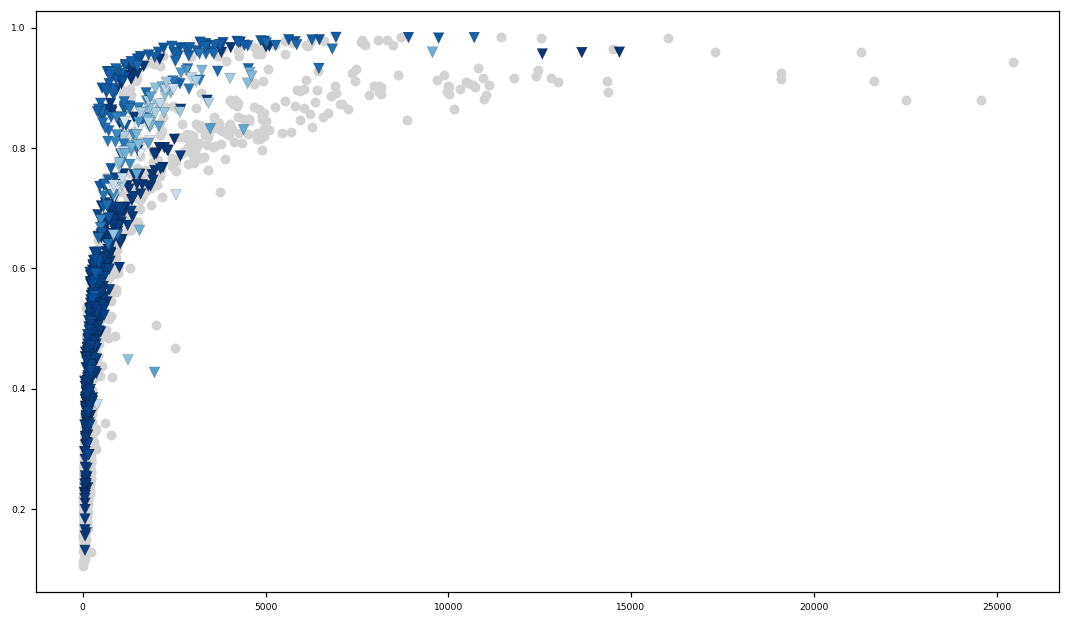

In [581]:
fig, _ = plt.subplots(figsize=(12,7))
plt.scatter(sc.obs["total_UMIs"].values[(sc.obs["clusters"] == "1") & ([cb in whitelist for cb in sc.obs_names])], sc.obs["max_corr"].values[(sc.obs["clusters"] == "1") & ([cb in whitelist for cb in sc.obs_names])], s = 30, c = "lightgray")
plt.scatter(sc.obs["total_UMIs"].values[(sc.obs["clusters"] == "0") & ([cb in whitelist for cb in sc.obs_names])], sc.obs["max_corr"].values[(sc.obs["clusters"] == "0") & ([cb in whitelist for cb in sc.obs_names])], s = 30, c = "lightgray")
plt.scatter(sc.obs["total_UMIs"].values[(sc.obs["clusters"] == "1") & ([cb not in whitelist for cb in sc.obs_names])], sc.obs["max_corr"].values[(sc.obs["clusters"] == "1") & ([cb not in whitelist for cb in sc.obs_names])], s = 50, c = "lightgray", marker = 'v', linewidths=0.2, edgecolors='black')
plt.scatter(sc.obs["total_UMIs"].values[(sc.obs["clusters"] == "0") & ([cb not in whitelist for cb in sc.obs_names])], sc.obs["max_corr"].values[(sc.obs["clusters"] == "0") & ([cb not in whitelist for cb in sc.obs_names])], s = 50, c = sc.obs["DedupRate"].values[(sc.obs["clusters"] == "0") & ([cb not in whitelist for cb in sc.obs_names])], cmap="Blues", vmin = 0, vmax = 1, marker = 'v', linewidths=0.1, edgecolors='black')

In [863]:
gm = GaussianMixture(2)
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
clusters = gm.fit_predict(np.array([sc.obs["max_corr"]/np.log1p(sc.obs["total_UMIs"])]).T).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)

sc.obs["clusters"] = clusters

In [954]:
gm = GaussianMixture(2, covariance_type="full")
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
# X = np.array([sc.obs["DedupRate"].loc[errors], sc.obs["max_corr"].loc[errors],np.log1p(sc.obs["total_UMIs"].loc[errors])]).T

X = np.array([sc.obs["DedupRate"].loc[errors]]).T

clusters = gm.fit_predict(X).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
# sc.obs["cluster_3"] = clusters_3
sc.obs["clusters"] = np.repeat(None, sc.X.shape[0])
# sc.obs["AT"] = np.repeat(False, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)
#     if barcode[0] == "T" and get_intended_barcodes(errors_dict, [barcode])[0][0][0] == "A" :
#         sc.obs["AT"].loc[barcode] = True
#     sc.obs["cluster_3"].iloc._setitem_with_indexer(np.argwhere(sc.obs_names.values == barcode)[0], cl)


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1025]:
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names.values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

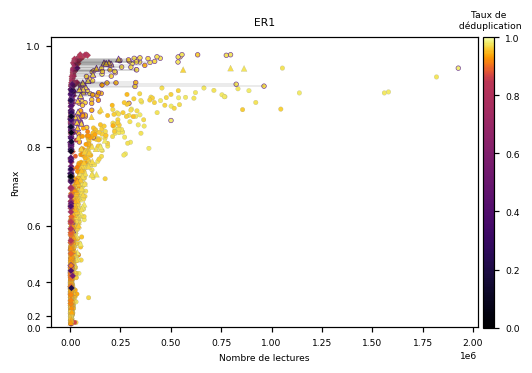

In [1137]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5,3.5))


errors = np.concatenate(list(errors_dict.values()))
# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "raw_cb_freq"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.85, vmax=1)
s = 9

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
i = 0
for barcode in sc.obs_names :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.9 and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.2, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
        i += 1
    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
        if Rmax in cl0 and Rmax in neighbors :
            edgecolors.append("rebeccapurple")
            linewidths.append(0.4)            
        else :
            edgecolors.append("gray")
            linewidths.append(0.1)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.7)
            if Rmax in cl0 and Rmax in neighbors :
                edgecolors.append("rebeccapurple")
                linewidths.append(0.5)            
            else :
                edgecolors.append("gray")
                linewidths.append(0.1)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            if Rmax in cl0 and Rmax in neighbors :
                edgecolors.append("rebeccapurple")
                linewidths.append(0.4)            
            else :
                edgecolors.append("gray")
                linewidths.append(0.1)


            
rnaseq.plotting.scatter(sc.obs[lib_type].values, sc.obs["max_corr"].values, sc.obs[color].values, marker = np.array(markers), \
            linewidth = np.array(linewidths), edgecolor = np.array(edgecolors), norm = norm, fig=fig, s = np.array(sizes), \
            cmap = cmap, order_marker= {'o':1, '^':2, 'D':3}, order_color = "descending", \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de lectures", ylabel = "Rmax", title = "ER1")            


plt.ticklabel_format(axis="x", style="sci")
ax.set_yscale("square")
plt.savefig("./test_max-corr-err.pdf")

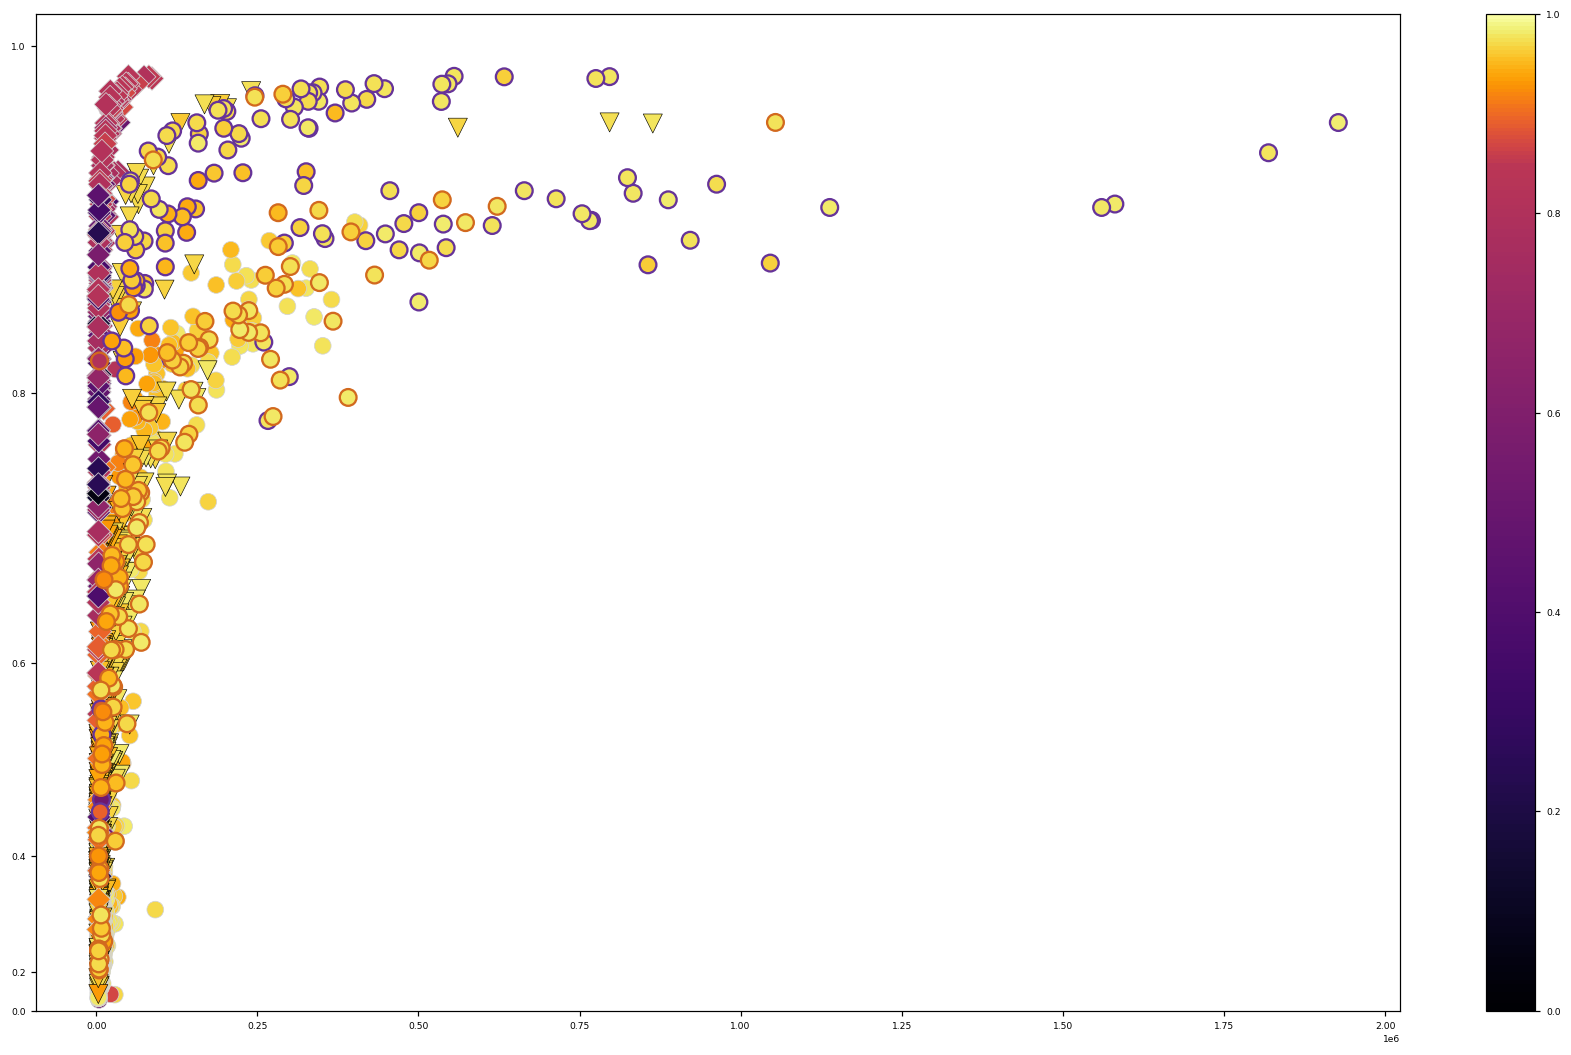

In [1071]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,12))


errors = np.concatenate(list(errors_dict.values()))
# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "raw_cb_freq"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.85, vmax=1)
s = 120


ax.scatter(sc.obs[lib_type].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           sc.obs["max_corr"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], s = s, \
           c = sc.obs[color].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           norm = norm, cmap = cmap, marker = 'o', linewidths=0.5, edgecolors='lightgray', zorder = 1)

ax.scatter(sc.obs[lib_type].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "0"] for cb \
        in sc.obs_names]], s = s, c = sc.obs[color].values[[cb in errors_dict.keys() and errors_dict[cb][0] \
        in sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], norm = norm, \
        cmap = cmap, marker = 'o', linewidths=1.5, edgecolors='rebeccapurple', zorder = 4)

ax.scatter(sc.obs[lib_type].values[sc.obs["clusters"] == "1"], sc.obs["max_corr"].values[sc.obs["clusters"] == "1"], \
        s = s*1.3, c = sc.obs[color].values[sc.obs["clusters"] == "1"], norm = norm, \
        marker = 'v', linewidths=0.4, cmap = cmap, edgecolors='black', zorder = 2)

scatt = ax.scatter(sc.obs[lib_type].values[sc.obs["clusters"] == "0"], sc.obs["max_corr"].values[sc.obs["clusters"] \
        == "0"], s = s, c = sc.obs[color].values[sc.obs["clusters"] == "0"], norm = norm, \
        marker = 'D', linewidths=0.5,  cmap = cmap, edgecolors='lightgray', zorder = 3)

ax.scatter(sc.obs[lib_type].values[[cb in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] \
        == "1"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], s = s, c = sc.obs[color].values[[cb in \
        errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], \
        norm = norm, cmap = cmap, marker = 'o', linewidths=1.5, \
        edgecolors='chocolate', zorder = 5)
fig.colorbar(scatt)


# i = 0
# cbs_2 = []
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] : #and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] < 0.85 and sc.obs["clusters"].loc[barcode1] == "1": # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 cbs_2.append(barcode1)
#                 x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                 i += 1



# i = 0
# for barcode1 in errors :
#         if sc.obs["max_corr"].loc[barcode1] > 0.96 and sc.obs["clusters"].loc[barcode1] == "1":
# #                 barcode2 = barcodes_corr_max.loc[barcode1][0]
#                 neighbors = neighbors_mtx.loc[barcode1]
#                 neighbors = neighbors.index.values[neighbors == 1]
#                 for barcode2 in neighbors :
#                     x = (sc.obs[lib_type].values[sc.obs["CB"] == barcode1], sc.obs[lib_type].values[sc.obs["CB"] == barcode2])
#                     y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                     ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                     i += 1
            
# ax.set_xscale("squareroot")
ax.set_yscale("square")
plt.savefig("./test_max-corr-err.pdf")

In [991]:
import pandas
import ast
sample = "Sample_N705_-_ER1"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [997]:
# cbs1_shared_umis = []
# cbs2_shared_umis = []
cbs1_shared_umis_err = []
cbs2_shared_umis_err = []
# random_shared_umis = []


for o,e in zip(get_intended_barcodes(errors_dict, cbs_1)[0], get_intended_barcodes(errors_dict, cbs_1)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    cbs1_shared_umis_err.append(shared_umis/n_umis)

for o,e in zip(get_intended_barcodes(errors_dict, cbs_2[:30])[0], get_intended_barcodes(errors_dict, cbs_2[:30])[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    cbs2_shared_umis_err.append(shared_umis/n_umis)

    
# for i in range(len(cbs_1)):
#     cb1,cb2 = np.random.choice(no_error, 2, replace = False)
#     umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
#     n_umis = len(umis_cb2) #+ len(umis_cb2)
#     shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
#     random_shared_umis.append(shared_umis/n_umis)

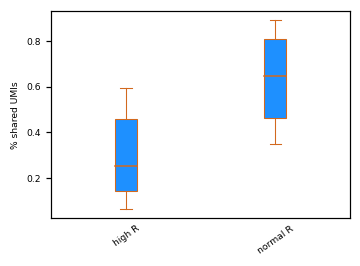

In [998]:
_, ax = plt.subplots(figsize=(3.5, 2.5))


bp = plt.boxplot(cbs1_shared_umis_err, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(cbs2_shared_umis_err, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

# bp = plt.boxplot(random_shared_umis, positions = [3], patch_artist = True,\
#                  boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
#                  whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
#                  capprops = {'linewidth': 0.7, 'color':'darkgray'},\
#                  medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
#                  flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,2), labels = ["high R", "normal R"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

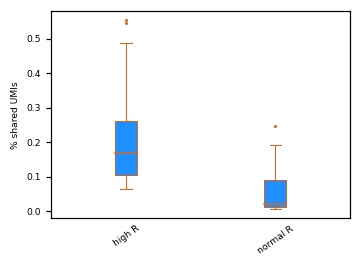

In [999]:
_, ax = plt.subplots(figsize=(3.5, 2.5))


bp = plt.boxplot(cbs1_shared_umis, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(cbs2_shared_umis, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

# bp = plt.boxplot(random_shared_umis, positions = [3], patch_artist = True,\
#                  boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
#                  whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
#                  capprops = {'linewidth': 0.7, 'color':'darkgray'},\
#                  medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
#                  flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,2), labels = ["high R", "normal R"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

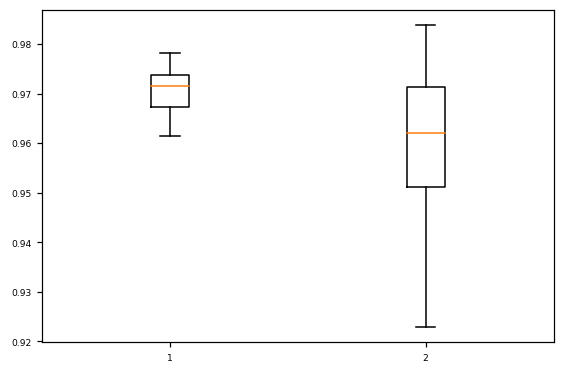

In [966]:
plt.boxplot([sc.obs["DedupRate"].loc[cbs_1], sc.obs["DedupRate"].loc[cbs_2]]);

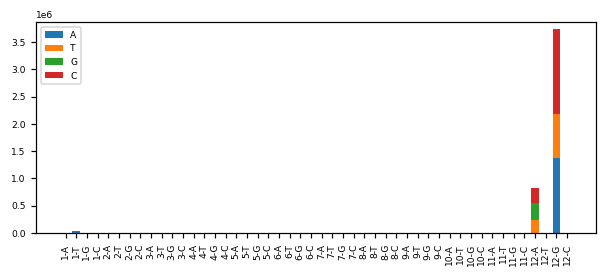

In [986]:
plot_errors(errors_dict, cbs_1)

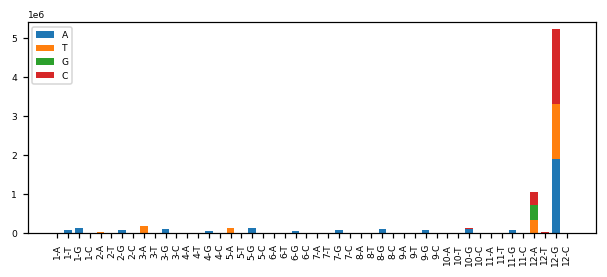

In [987]:
plot_errors(errors_dict, cbs_2)

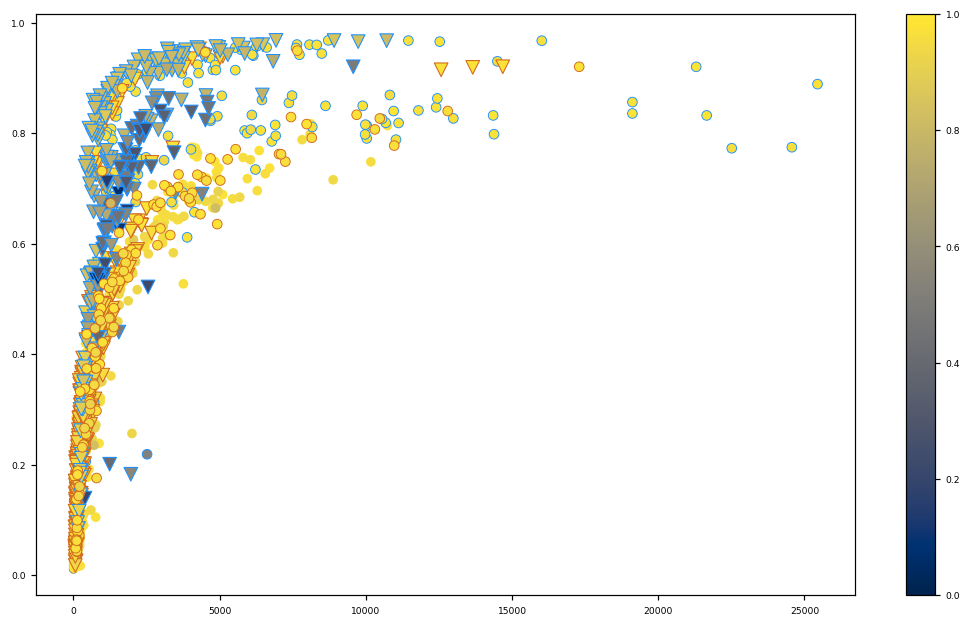

In [985]:
fig, ax = plt.subplots(figsize=(12,7))


errors = np.concatenate(list(errors_dict.values()))

ax.scatter(sc.obs["total_UMIs"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           sc.obs["max_corr"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], s = 40, \
           c = sc.obs["DedupRate"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           vmin = 0, vmax = 1, cmap = "cividis", marker = 'o', linewidths=0, edgecolors='black', zorder = 1)
ax.scatter(sc.obs["total_UMIs"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "0"] for cb \
        in sc.obs_names]], s = 40, c = sc.obs["DedupRate"].values[[cb in errors_dict.keys() and errors_dict[cb][0] \
        in sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], vmin = 0, vmax = 1, cmap = "cividis", \
        marker = 'o', linewidths=0.6, edgecolors='dodgerblue', zorder = 2)
ax.scatter(sc.obs["total_UMIs"].values[sc.obs["clusters"] == "1"], sc.obs["max_corr"].values[sc.obs["clusters"] == "1"], \
        s = 80, c = sc.obs["DedupRate"].values[sc.obs["clusters"] == "1"], vmin = 0, vmax = 1, marker = 'v', linewidths=0.7, \
        cmap = "cividis", edgecolors='chocolate', zorder = 3)
scatt = ax.scatter(sc.obs["total_UMIs"].values[sc.obs["clusters"] == "0"], sc.obs["max_corr"].values[sc.obs["clusters"] \
        == "0"], s = 80, c = sc.obs["DedupRate"].values[sc.obs["clusters"] == "0"], vmin = 0, vmax = 1, marker = 'v', \
        linewidths=0.7,  cmap = "cividis", edgecolors='dodgerblue', zorder = 4)
ax.scatter(sc.obs["total_UMIs"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] \
        == "1"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], s = 40, c = sc.obs["DedupRate"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], \
        vmin = 0, vmax = 1, cmap = "cividis", marker = 'o', linewidths=0.6, edgecolors='chocolate', zorder = 5)
fig.colorbar(scatt)

# i = 0
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2]:# and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.8 and sc.obs["clusters"].loc[barcode1] == "1": # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                 i += 1
                
# ax.set_xscale("squareroot")
ax.set_yscale("square")

In [485]:
get_intended_barcodes(errors_dict, ["TAAGAGTGGTTA"])

(array(['TAAGAGTGGTTG'], dtype='<U12'), array(['TAAGAGTGGTTA'], dtype='<U12'))

In [486]:
sc.obs.loc[["TAAGAGTGGTTG", "TAAGAGTGGTTA"]]

CB  CorrectedReads  MappedReads  DeduplicatedReads  \
CB                                                                           
TAAGAGTGGTTG  TAAGAGTGGTTG           79392        53516               1349   
TAAGAGTGGTTA  TAAGAGTGGTTA           76038        51388               1390   

              MappingRate  DedupRate  MeanByMax  NumGenesExpressed  \
CB                                                                   
TAAGAGTGGTTG     0.674073   0.974793   0.118188                878   
TAAGAGTGGTTA     0.675820   0.972951   0.089263                916   

              NumGenesOverMean  raw_cb_freq            samples project_id  \
CB                                                                          
TAAGAGTGGTTG               216        71604  Sample_N705_-_ER1     dsp779   
TAAGAGTGGTTA               220        69048  Sample_N705_-_ER1     dsp779   

              total_UMIs  max_corr cluster_3 first_pos     AT  
CB                                                             
TAAGAGTGGTTG      1349.0  0.714651  no error         T  False  
TAAGAGTGGTTA      1390.0  0.732874         2         T  False

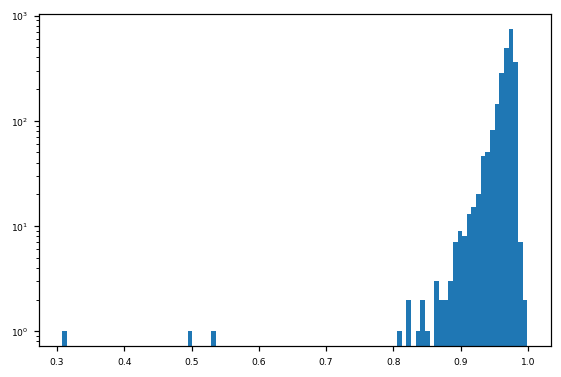

In [711]:
plt.hist(sc.obs["DedupRate"].loc[whitelist], bins = 100);
plt.yscale("log");

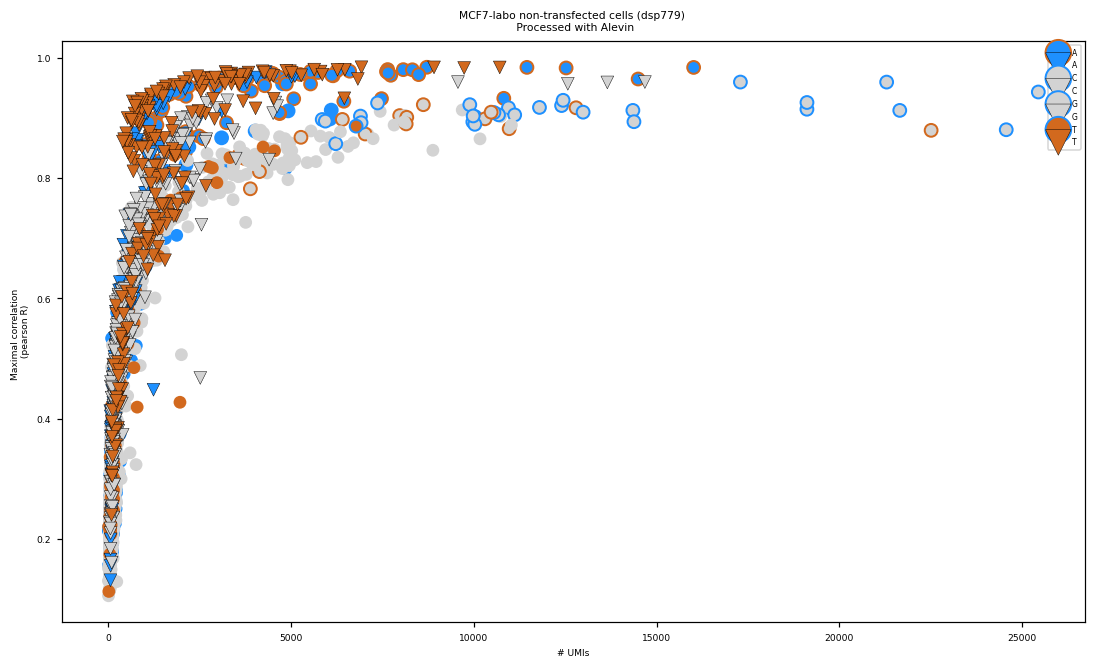

In [316]:
fig, _ = plt.subplots(figsize=(12,7))

i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)


# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1


originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])
        

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 70, color = sc.obs["first_pos"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'A' : "dodgerblue", 'T' : "chocolate", 'G':"lightgray", "C" : "lightgray"}, \
                        marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

In [311]:
ord("T")

84

In [310]:
np.unique(sc.obs["first_pos"].values)

array(['65', '67', '71', '84'], dtype=object)

In [242]:
sc.obs["DedupRate"][(sc.obs["max_corr"] > 0.5) & (sc.obs["max_corr"] < 0.8) & (sc.obs["cluster_3"] == "1")]

CB
GTCCTGTCTTTC    0.876633
CATTTTGAGCCG    0.878114
TTATTAAGGTAG    0.875855
AATTGCAGCGGC    0.848902
GGTCAGTGATCC    0.865594
GGCACTTAGAGC    0.842497
GGTCAGAGGGAA    0.843113
ACGCGCTTGAGC    0.655896
GGGACATCCGTA    0.810891
CCCCTGCGGAGG    0.825113
CACTGACTATCT    0.882030
GATATAGGTACG    0.846256
GCCCCTGCGGAG    0.792556
CAGTTACTATCT    0.849254
CCCCAAGGATCC    0.832816
GACTCCACTGTG    0.846935
GGGTCCCGGCAG    0.787729
GACCCCAAGAAA    0.740555
GACGCCAACAAA    0.663717
ACCCCTGCGGAG    0.757986
ATGCGCTTGAGC    0.851606
GACTCCAAGAAA    0.800000
GGCACCCCTTCG    0.818443
CTGCGCTTGAGC    0.764265
GCCGCGGCGGGG    0.658326
CCGCGCTTCAGC    0.701787
CTTGTACATGCA    0.832796
TCGCTGACGAGG    0.650892
GCGCTTGTCTGC    0.806971
GGTCTCAAGAGC    0.841255
Name: DedupRate, dtype: float64

In [244]:
sc.obs["DedupRate"][(sc.obs["max_corr"] > 0.92) & (sc.obs["cluster_3"] == "1")]

CB
TGTAATTGCTAG    0.843603
TTGTAGATTCTT    0.852614
TCTAGCGGTGCG    0.805149
TCGAGGCCAACT    0.861638
TTCTGCAGGGGT    0.849281
                  ...   
TTGTGTTCTCAC    0.817360
TCGGCGGAACAT    0.851230
TGGATAATACGA    0.814359
TTCATCCGGACA    0.854443
TCAGAGTTAACC    0.800403
Name: DedupRate, Length: 64, dtype: float64

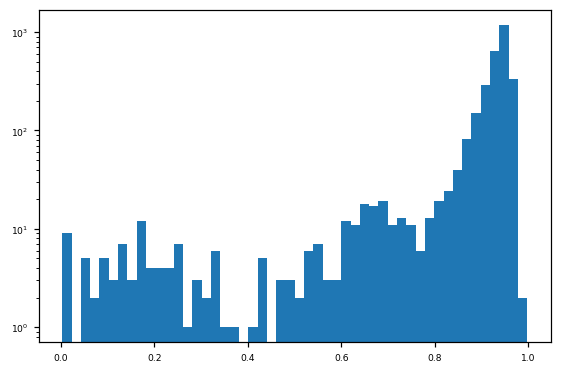

In [240]:
plt.hist(sc.obs["DedupRate"]**2, bins=50);
plt.yscale("log");

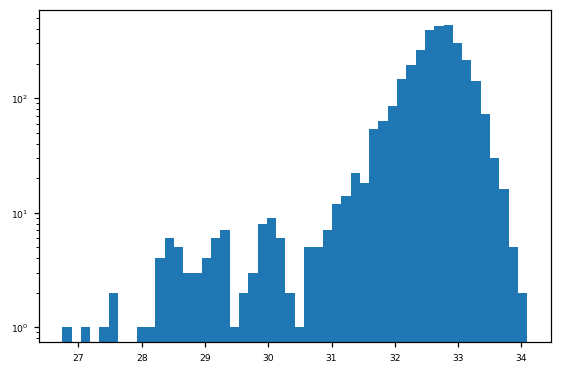

In [241]:
plt.hist(total_scores.mean(1), bins=50);
plt.yscale("log");

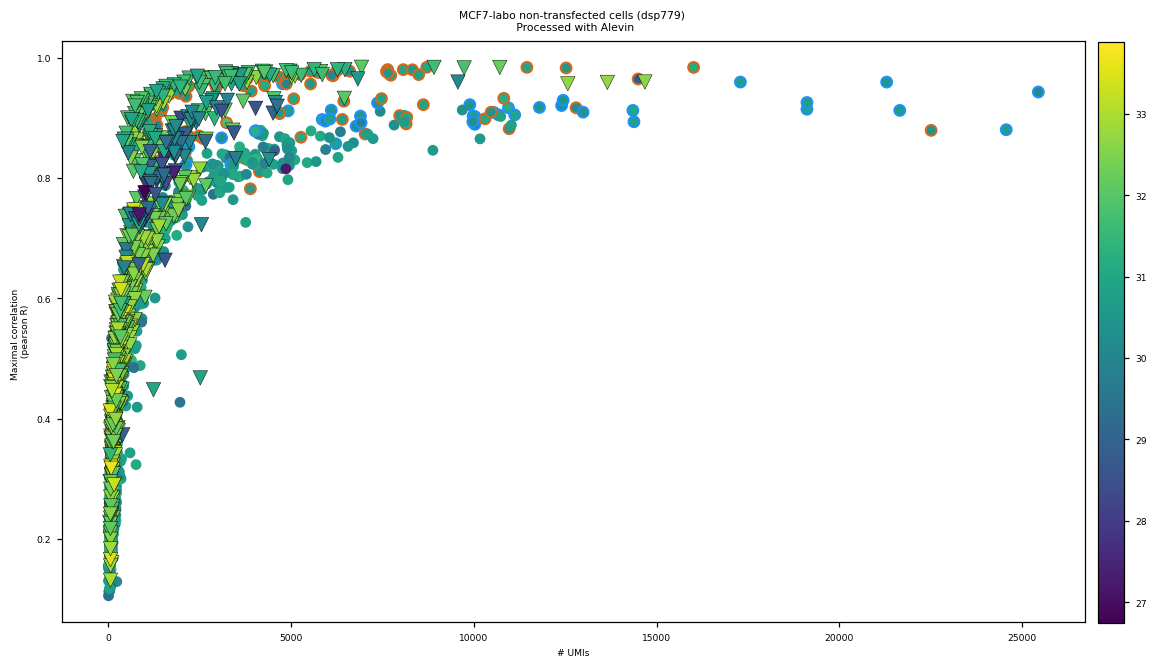

In [214]:
fig, _ = plt.subplots(figsize=(12,7))

i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)


# i = 0
# errors = np.concatenate(list(errors_dict.values()))
# # errors_to_corr = sc.
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 plt.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.2)
#                 i += 1


originals_max_low = []
originals_max_mid = []
errors = np.concatenate(list(errors_dict.values()))
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            if barcode1 in errors_low_dedup :
                originals_max_low.append(barcode2)
            elif barcode1 in errors_mid_dedup :
                originals_max_mid.append(barcode2)               
                
unique_originals_max_low = list(np.setdiff1d(originals_max_low, originals_max_mid))
unique_originals_max_mid = list(np.setdiff1d(originals_max_mid, originals_max_low))
for barcode in np.intersect1d(originals_max_low, originals_max_mid) :
    x = sc.obs["max_corr"].loc[errors_dict[barcode]]
    idx = x.values.argmax()
    max_barcode = x.index[idx]
    if max_barcode in errors_low_dedup :
        unique_originals_max_low.append(barcode)
    elif max_barcode in errors_mid_dedup :
        unique_originals_max_mid.append(barcode)

sizes = np.array([50 if barcode in whitelist else 90 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.3 for barcode in sc.obs_names])
l = np.array([1.3 if barcode in np.concatenate([unique_originals_max_low, unique_originals_max_mid]) else li for barcode,li in zip(sc.obs_names,l)])
e = np.array(["chocolate" if barcode in unique_originals_max_mid else "lightgray" for barcode in sc.obs_names])
e = np.array(["dodgerblue" if barcode in unique_originals_max_low else ei for barcode,ei in zip(sc.obs_names,e)])
e = np.array(["black" if barcode not in whitelist else ei for barcode,ei in zip(sc.obs_names,e)])
        

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = sizes, color = total_scores.mean(1),\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor=e, linewidth=l, \
                        palette = {'0' : "dodgerblue", '1' : "chocolate", '2':"lightgray"},
                        order_color= ['2','1','0'], marker=markers, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

(3000,)

In [931]:
libs = sc.obs["total_UMIs"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

# sc._inplace_subset_obs([barcode in np.concatenate(errors_dict.keys(), errors_dict.values()) for barcode in sc.obs_names])

2305 barcodes in the new whitelist


In [1055]:
intended = get_intended_barcodes(errors_dict, errors_low_dedup)
idx = sc.obs["total_UMIs"].loc[intended].values > 12000
barcodes = np.array([list(b) for b in np.array(intended)[idx]]).T
for pos in barcodes:
    print(np.unique(pos, return_counts=True))

(array(['A', 'C', 'G'], dtype='<U1'), array([ 4, 31, 12]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([23, 18,  4,  2]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([ 6, 14, 16, 11]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([ 8, 16, 10, 13]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([ 8,  8, 28,  3]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([11, 22,  3, 11]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([ 6, 12, 13, 16]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([11,  8, 14, 14]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([13, 14, 18,  2]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([14,  1, 10, 22]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([11, 12,  9, 15]))
(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([11, 21,  5, 10]))


In [263]:
(np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"])) / np.sum(sc.obs["select"] == "whitelist (low dedup)")

356359.71428571426

In [266]:
(np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"])) / np.sum(sc.obs["select"] == "whitelist (low dedup)")

9296.671428571428

In [232]:
np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]) / (np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]))

0.052305954694076895

In [811]:
barcodes = sc.obs["CB"].values

n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]
pd.DataFrame(np.unique(n_neighbors, return_counts=True))

0    1   2   3  4  5  6
0     0    1   2   3  4  5  6
1  2694  217  36  39  9  4  1

In [492]:
barcodes = sc.obs["CB"].values

n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]
pd.DataFrame(np.unique(n_neighbors, return_counts=True))

0    1    2    3   4   5   6   7   8   9   10  11  12
0     0    1    2    3   4   5   6   7   8   9  11  12  14
1  2078  388  129  274  94  13   7   9   4   1   1   1   1

In [486]:
barcodes = sc.obs["CB"].values

n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]
pd.DataFrame(np.unique(n_neighbors, return_counts=True))

0    1    2    3   4   5   6   7   8   9   10  11  12
0     0    1    2    3   4   5   6   7   8   9  10  12  14
1  2066  394  132  281  90  16   9   6   2   1   1   1   1

In [281]:
barcodes = sc.obs["CB"].values

neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs["CB"].values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

connected_components = connectedComponents(neighbors_mtx)

In [123]:
connected_components

array([list(['CCTTGTCGCGTG', 'CCTTGTCGCGTC', 'CCTTGTCGCGTA', 'CCTTGTCGCGTT', 'CCTTGTCGCGGT', 'CCTTGTCGCGGA', 'CCTTGTCGCGGG', 'CCTTGTCGCGGC', 'CCTTGTCGCATT', 'CCTTGTCGCATG', 'CCTTGTCGCATC', 'CCTTGTCGCATA', 'CCTTGTCACGTT', 'CCTTGTCACGTG', 'CCTTGTCACGTC', 'CCTTGTCACGTA', 'CCTTATCGCGTT', 'CCTTATCGCGTG', 'CCTTATCGCGTC', 'CCTTATCGCGTA', 'GCTTGTCGCGTG']),
       list(['CCGCGCTTGAGC', 'CCGCGCTTGCGC', 'CCGCGCTTAAGC', 'CCGCGCTTCAGC', 'CCACGCTTGAGC', 'CCGCACTTGAGC', 'CCGCGCTTGAAC', 'GCGCGCTTGAGC', 'ACGCGCTTGAGC', 'ATGCGCTTGAGC', 'ATGCGCTTGACC', 'CTGCGCTTGAGC', 'CCGCGCGTGAGC', 'CCGCGCATGAGC', 'CCGCGCTAGAGC', 'CCGCGCTTGAGA', 'CCGCGATTGAGC']),
       list(['GACGCCAAGAAA', 'GCCGCCAAGAAA', 'GGCGCCAAGAAA', 'TACGCCAAGAAA', 'AACGCCAAGAAA', 'CACGCCAAGAAA', 'GACACCAAGAAA', 'GACCCCAAGAAA', 'GACTCCAAGAAA', 'GACGCCAAAAAA', 'GACGCCAACAAA', 'GACGCAAAGAAA', 'GACGCCAAGAAC']),
       ..., list(['ATCTCCGTGCGG']), list(['AGTCAGCCAACA']),
       list(['GCGTGCCAACTG'])], dtype=object)

In [479]:
rnaseq.pp.log_norm(sc)
scanpy.pp.neighbors(sc, n_pcs=20)
scanpy.tl.umap(sc)

Normalization by total UMIs...
Log2 + 1 tranformation...
         Falling back to preprocessing with `sc.pp.pca` and default params.


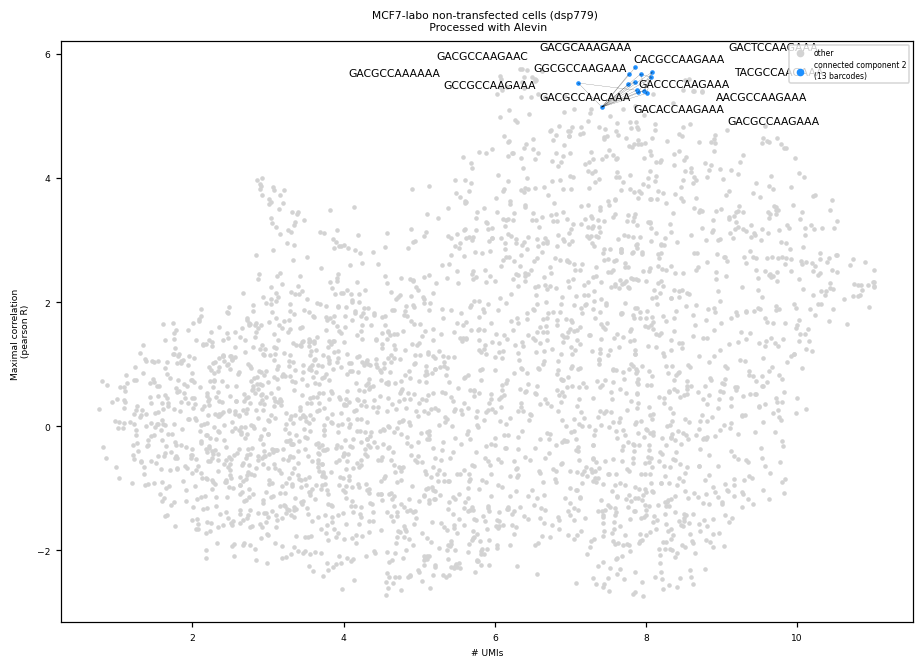

In [480]:
fig,_ = plt.subplots(figsize=(10,7))

i = 0.1

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc[barcode1].obsm["X_umap"].T[0], sc[barcode2].obsm["X_umap"].T[0])
            y = (sc[barcode1].obsm["X_umap"].T[1], sc[barcode2].obsm["X_umap"].T[1])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc[barcode1].obsm["X_umap"].T[0],\
                              sc[barcode1].obsm["X_umap"].T[1], barcode1, fontsize = 7))


rnaseq.plotting.scatter(sc.obsm["X_umap"].T[0], sc.obsm["X_umap"].T[1], s = 4, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.show()

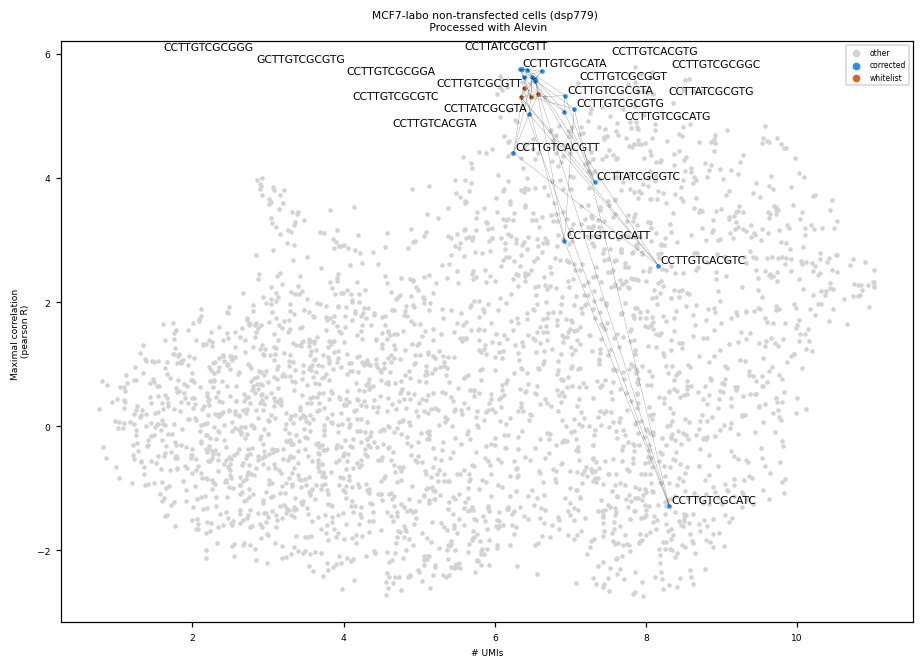

In [481]:
fig,_ = plt.subplots(figsize=(10,7))

i = 0

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component and barcode in whitelist :
        select.append(f"whitelist")
    elif barcode in component :
        select.append("corrected")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc[barcode1].obsm["X_umap"].T[0], sc[barcode2].obsm["X_umap"].T[0])
            y = (sc[barcode1].obsm["X_umap"].T[1], sc[barcode2].obsm["X_umap"].T[1])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc[barcode1].obsm["X_umap"].T[0],\
                              sc[barcode1].obsm["X_umap"].T[1], barcode1, fontsize = 7))


rnaseq.plotting.scatter(sc.obsm["X_umap"].T[0], sc.obsm["X_umap"].T[1], s = 4, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"corrected" : "dodgerblue", "whitelist": "chocolate", "other":"lightgray"},\
                        order_color = ["other", f"corrected", "whitelist"], fig = fig)
adjust_text(texts)

plt.show()

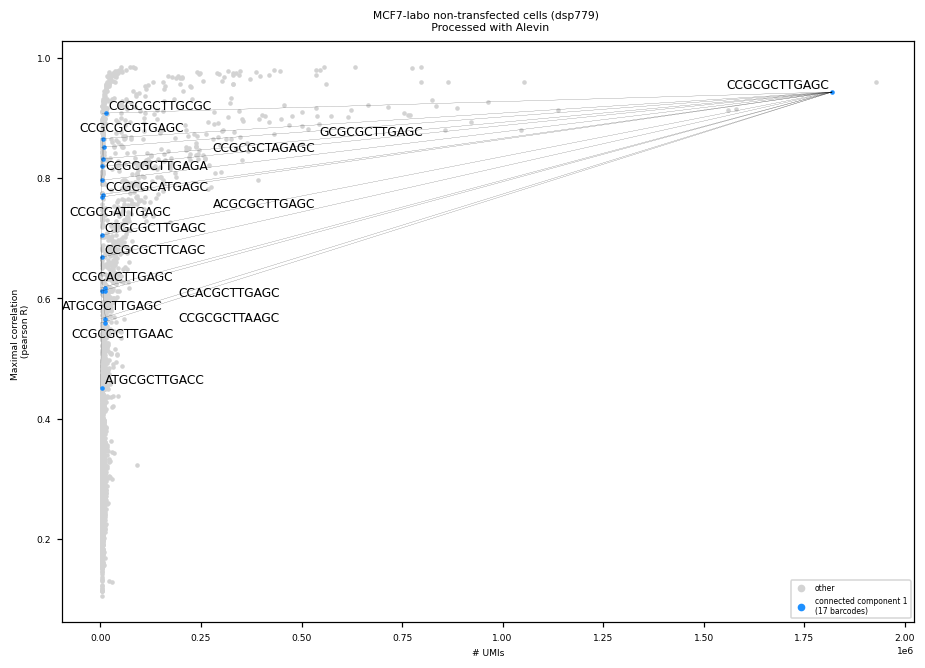

In [148]:
fig,_ = plt.subplots(figsize=(10,7))

i = 1

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], barcode1, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 4, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

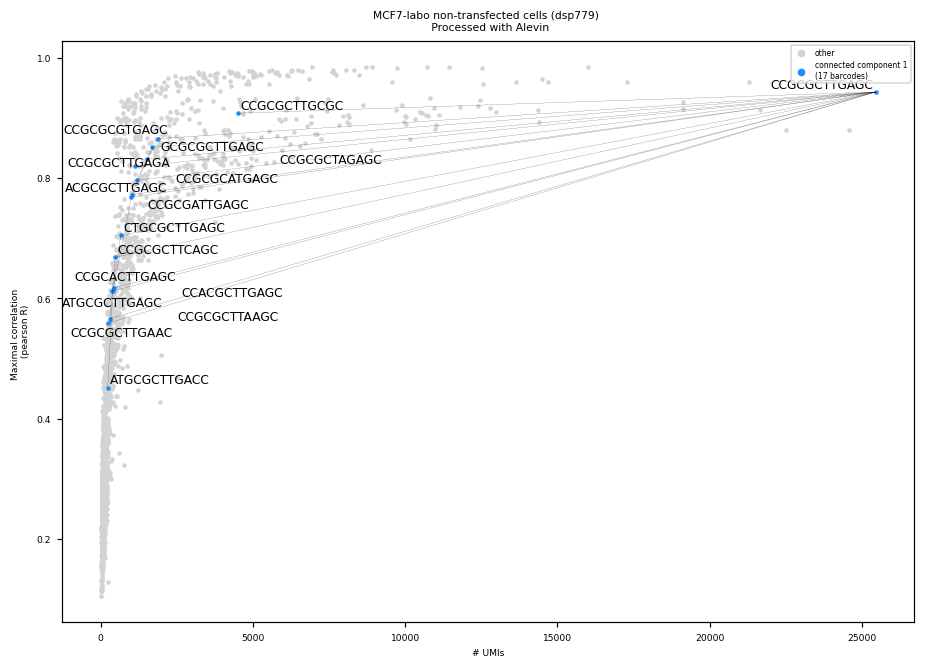

In [147]:
fig,_ = plt.subplots(figsize=(10,7))

i = 1

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], barcode1, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 4, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

In [1431]:
b = sc.obs_names[np.array(n_neighbors) == 14][0]
dedup = sc.obs["DedupRate"].loc[errors_dict[b]]
phred = np.mean(total_scores[[cb in errors_dict[b] for cb in sc.obs_names]], axis = 1)

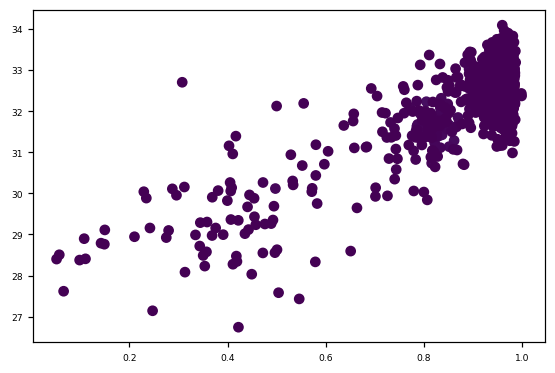

In [1439]:
dedup = sc.obs["DedupRate"]
phred = np.mean(total_scores, axis = 1)
plt.scatter(dedup, phred, c=sc.obs["raw_cb_freq"])

In [1391]:
b

'CCGCGCTTGAGC'

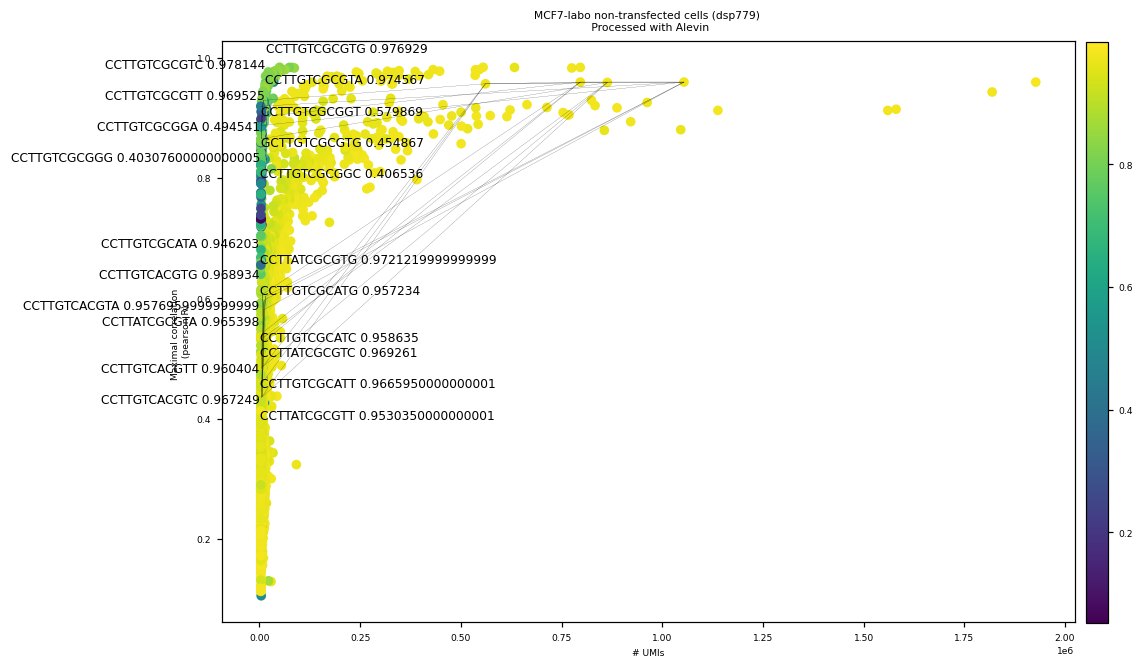

In [1404]:
fig,_ = plt.subplots(figsize=(10,7))

i = 0

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    dedup = sc.obs["DedupRate"].loc[barcode1]
    t = f"{barcode1} {dedup}"
    texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], t, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 40, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", linewidth = 0, \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

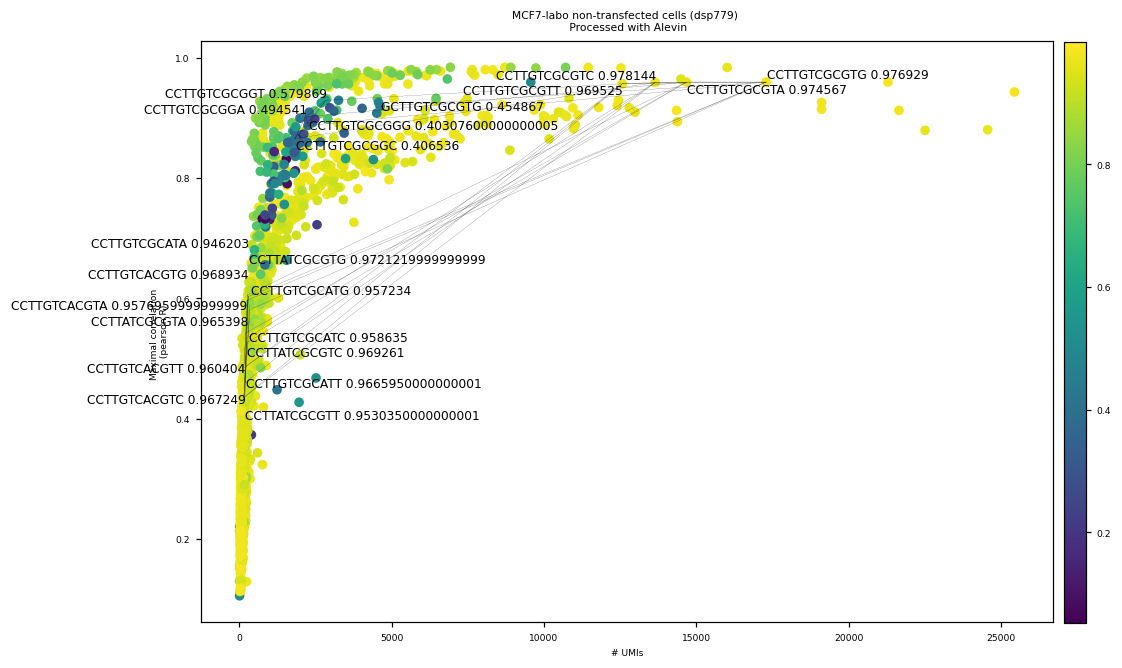

In [1409]:
fig,_ = plt.subplots(figsize=(10,7))

i = 0

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    dedup = sc.obs["DedupRate"].loc[barcode1]
    t = f"{barcode1} {dedup}"
    texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], t, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 40, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", linewidth = 0, \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

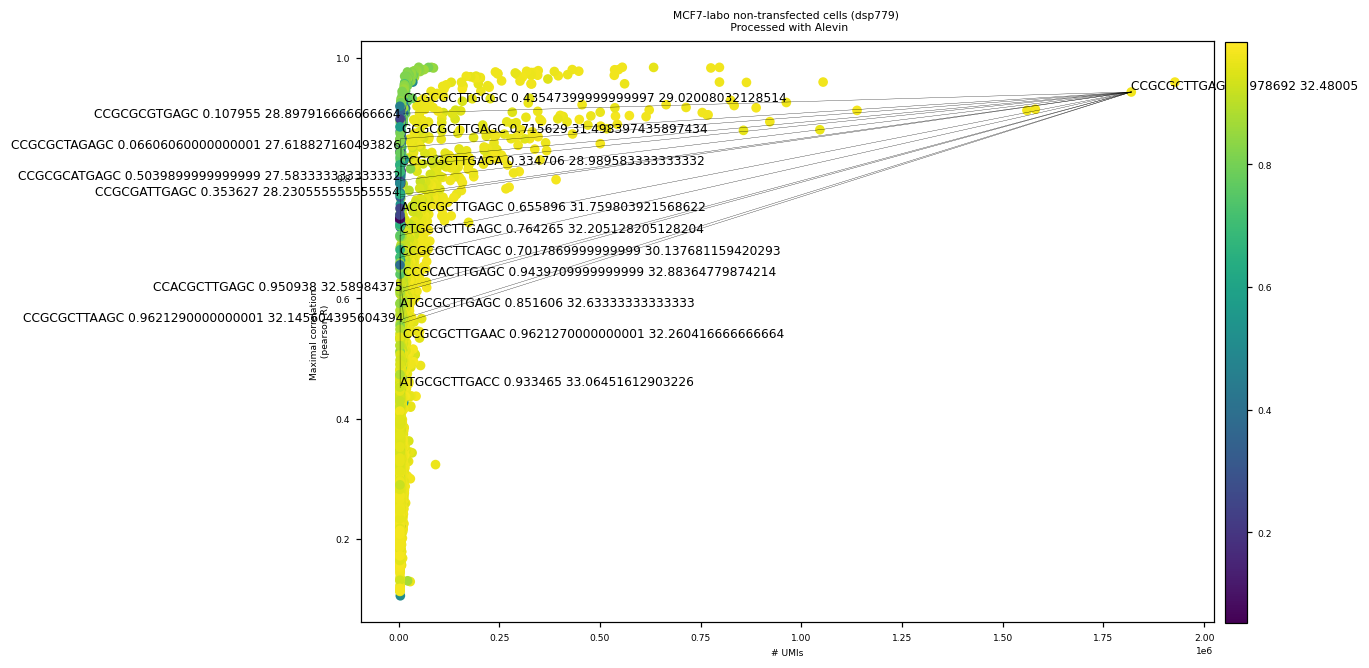

In [1440]:
fig,_ = plt.subplots(figsize=(10,7))

i = 1

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.2, color = "black")
            explored.append({barcode1, barcode2})
    dedup = sc.obs["DedupRate"].loc[barcode1]
    phred = total_scores[sc.obs_names == barcode1].mean()
    t = f"{barcode1} {dedup} {phred}"
    texts.append(plt.text(sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], t, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 40, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", linewidth=0,\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

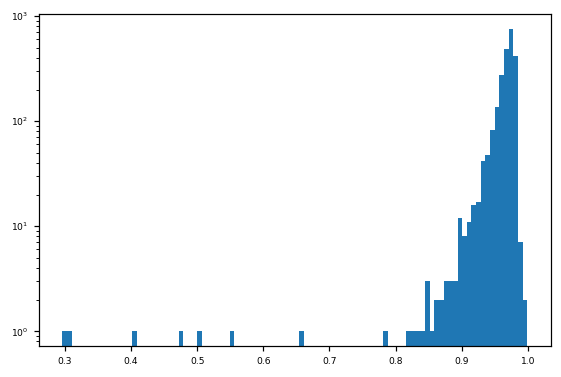

In [1443]:
plt.hist(sc.obs["DedupRate"].loc[whitelist], bins = 100);
plt.yscale('log');

In [1453]:
sc.obs["DedupRate"].loc[whitelist][sc.obs["DedupRate"] < 0.7]

CB
ACGCGCTTGAGC    0.655896
GCCACCCCTTCG    0.406859
GACACACCTTCG    0.471983
AGCCGAGCTTCG    0.295985
TGGGGGGGGGGG    0.555127
TCAAATACGTGG    0.307692
CCGACAAACCTA    0.500000
Name: DedupRate, dtype: float64

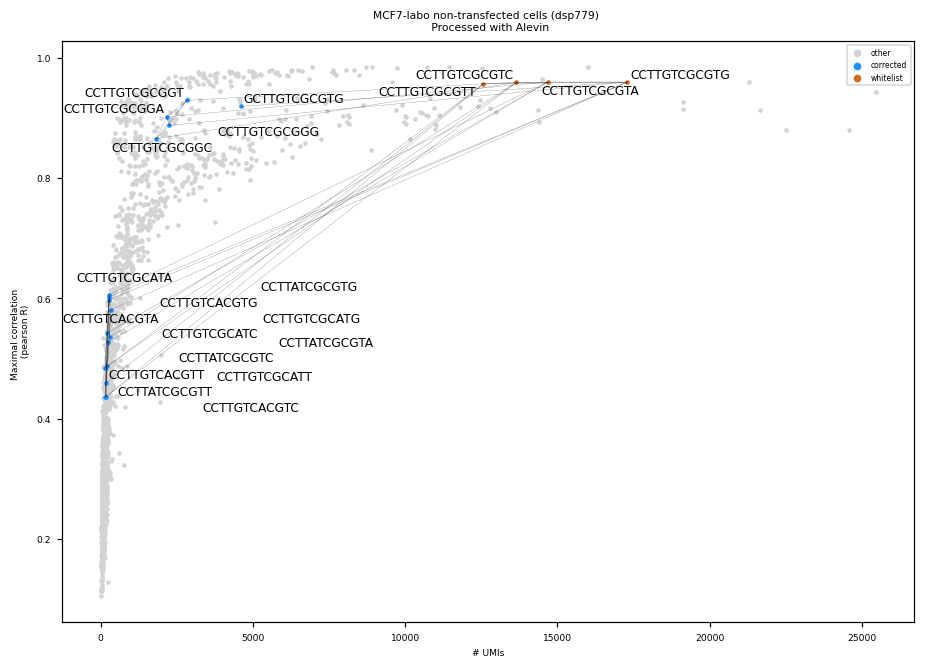

In [545]:
fig,_ = plt.subplots(figsize=(10,7))

i = 0

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component and barcode in whitelist :
        select.append(f"whitelist")
    elif barcode in component :
        select.append("corrected")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], barcode1, fontsize = 8))


rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 4, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"corrected" : "dodgerblue", "whitelist": "chocolate", "other":"lightgray"},\
                        order_color = ["other", f"corrected", "whitelist"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

(array([ 2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 16.]),
 array([0.403076  , 0.44141387, 0.47975173, 0.5180896 , 0.55642747,
        0.59476533, 0.6331032 , 0.67144107, 0.70977893, 0.7481168 ,
        0.78645467, 0.82479253, 0.8631304 , 0.90146827, 0.93980613,
        0.978144  ]),
 <BarContainer object of 15 artists>)

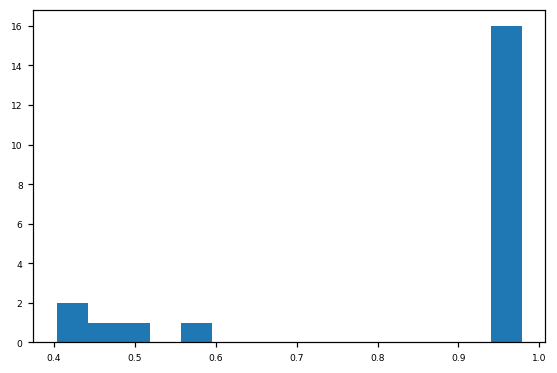

In [136]:
plt.hist(sc[component].obs["DedupRate"], bins = 15)

In [139]:
sc[np.array(n_neighbors)==14].obs_names

Index(['CCGCGCTTGAGC'], dtype='object', name='CB')

In [159]:
len(connected_components[1])

17

In [1122]:
import scipy
n_neighbors_cl0 = neighbors_mtx.loc[cl0].sum(0)
scipy.stats.pearsonr(n_neighbors_cl0, sc.obs["raw_cb_freq"].values)

(0.6090336364584721, 4.3318544337485306e-304)

In [1120]:
n_neighbors_cl1 = neighbors_mtx.loc[cl1].sum(0)
scipy.stats.pearsonr(n_neighbors_cl1, sc.obs["raw_cb_freq"].values)

(0.46206480491256857, 1.4042044723523136e-158)

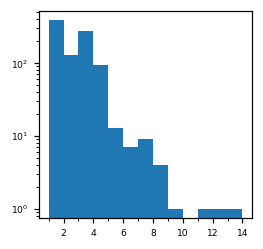

In [485]:
_,ax = plt.subplots(figsize=(2.5,2.5))
nnu = np.unique(n_neighbors[n_neighbors > 0])
plt.hist(n_neighbors[n_neighbors > 0], bins=np.max(nnu)-1)
plt.yscale('log')
ax.set_xticks(np.arange(2,np.max(nnu)+1,2))
ax.set_xticks(np.arange(1,np.max(nnu)+1,2), minor=True)
plt.savefig("./figs/dist-nn.pdf")

In [181]:
nnu

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 14])

In [173]:
np.unique([len(c) for c in connected_components])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17, 21])

### Low dedup population, nearest correlations

In [35]:
del sc.obs["select"]

In [36]:
low_dedup_barcodes = sc.obs["CB"].values[sc.obs["DedupRate"] < 0.7]
barcodes = sc.obs["CB"].values

i_corr_max = np.argsort(np.corrcoef(sc.X.toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs["CB"].values[i_corr_max], index = sc.obs["CB"].values)

neighbors_mtx = np.empty((len(low_dedup_barcodes), len(barcodes)))  
for i in range(len(low_dedup_barcodes)) :
    barcode1 = low_dedup_barcodes[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = low_dedup_barcodes, dtype=int)


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


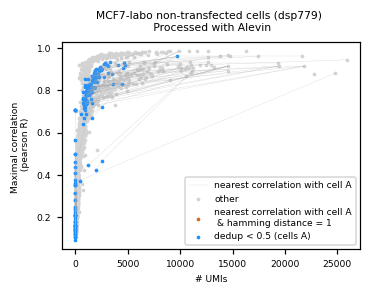

In [37]:
fig, _ = plt.subplots(figsize=(3.5,2.5))

sc.obs["select"] = ["dedup < 0.5 (cells A)" if (d < 0.7) else "other" for d in sc.obs["DedupRate"]]

i = 0
j = 0
for barcode1 in low_dedup_barcodes :
    for barcode2 in barcodes :
        if barcodes_corr_max.loc[barcode1][0] == barcode2 :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "darkgray", label = "nearest correlation with cell A" if i == 0 else "")
            i += 1
            if neighbors_mtx.loc[barcode1][barcode2] == 1 :
                sc.obs["select"][barcode2] = "nearest correlation with cell A\n & hamming distance = 1"
                j +=1
            
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"],\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"dedup < 0.5 (cells A)" : "dodgerblue", "nearest correlation with cell A\n & hamming distance = 1" : "chocolate", "other" : "lightgray"},\
                        order_color = ["other","nearest correlation with cell A\n & hamming distance = 1", "dedup < 0.5 (cells A)"], fig = fig)

plt.legend();

In [43]:
low_dedup_barcodes = sc.obs["CB"].values[sc.obs["DedupRate"] < 0.9]
barcodes = sc.obs["CB"].values

i_corr_max = np.argsort(np.corrcoef(sc.X.toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs["CB"].values[i_corr_max], index = sc.obs["CB"].values)

neighbors_mtx = np.empty((len(low_dedup_barcodes), len(barcodes)))  
for i in range(len(low_dedup_barcodes)) :
    barcode1 = low_dedup_barcodes[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = low_dedup_barcodes, dtype=int)


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


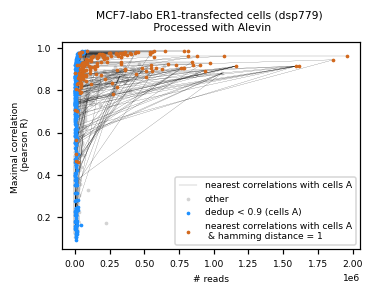

In [46]:
fig, _ = plt.subplots(figsize=(3.5,2.5))

sc.obs["select"] = ["dedup < 0.9 (cells A)" if (d < 0.9) else "other" for d in sc.obs["DedupRate"]]

i = 0
j = 0
for barcode1 in low_dedup_barcodes :
    for barcode2 in barcodes :
        if barcodes_corr_max.loc[barcode1][0] == barcode2 :
            x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black", label = "nearest correlations with cells A" if i == 0 else "", zorder = 2)
            i += 1
            if neighbors_mtx.loc[barcode1][barcode2] == 1 :
                sc.obs["select"][barcode2] = "nearest correlations with cells A\n & hamming distance = 1"
                j +=1
            
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"],\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo ER1-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"dedup < 0.9 (cells A)" : "dodgerblue", "nearest correlations with cells A\n & hamming distance = 1" : "chocolate", "other" : "lightgray"},\
                        order_color = ["other", "dedup < 0.9 (cells A)", "nearest correlations with cells A\n & hamming distance = 1"],\
                        fig = fig, zorder=[1,3,4])

plt.legend();

In [47]:
print(f"{j} cells over the {i} low dedup cells have a hamming distance of 1 with its nearest correlating cell.")

202 cells over the 363 low dedup cells have a hamming distance of 1 with its nearest correlating cell.


### Errors patterns

In [476]:
errors_dict

{'CCTTGTCGCGTG': ['CCTTGTCGCGTC',
  'CCTTGTCGCGTA',
  'CCTTGTCGCGTT',
  'CCTTATCGCGTG',
  'CCTTGTCACGTG',
  'CCTTGTCGCATG',
  'CCTTGTCGCGGG',
  'GCTTGTCGCGTG'],
 'CCTTGTCGCGTC': ['CCTTGTCGCATC',
  'CCTTATCGCGTC',
  'CCTTGTCACGTC',
  'CCTTGTCGCGGC'],
 'CCTTGTCGCGTA': ['CCTTATCGCGTA',
  'CCTTGTCGCATA',
  'CCTTGTCACGTA',
  'CCTTGTCGCGGA'],
 'CCTTGTCGCGTT': ['CCTTGTCGCGGT',
  'CCTTGTCGCATT',
  'CCTTGTCACGTT',
  'CCTTATCGCGTT'],
 'CCGCGCTTGAGC': ['CCGCGCTTGCGC',
  'CCGCGCTTAAGC',
  'CCACGCTTGAGC',
  'CCGCACTTGAGC',
  'CCGCGCTTGAAC',
  'GCGCGCTTGAGC',
  'CCGCGCGTGAGC',
  'CCGCGCTAGAGC',
  'ACGCGCTTGAGC',
  'CCGCGCTTGAGA',
  'CCGCGCATGAGC',
  'CCGCGATTGAGC',
  'CTGCGCTTGAGC',
  'CCGCGCTTCAGC'],
 'ACGCGCTTGAGC': ['ATGCGCTTGAGC'],
 'ATGCGCTTGAGC': ['ATGCGCTTGACC'],
 'GACGCCAAGAAA': ['GCCGCCAAGAAA',
  'TACGCCAAGAAA',
  'GACACCAAGAAA',
  'AACGCCAAGAAA',
  'GACGCCAAAAAA',
  'CACGCCAAGAAA',
  'GACGCAAAGAAA',
  'GGCGCCAAGAAA',
  'GACCCCAAGAAA',
  'GACGCCAACAAA',
  'GACTCCAAGAAA',
  'GACGCCAAGAAC'],


In [1600]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2305 barcodes in the new whitelist


In [773]:
originals_low_dedup = []
errors_low_dedup = []
originals_normal_dedup = []
errors_normal_dedup = []

for original in errors_dict.keys():
    for error in errors_dict[original] :
        if sc.obs["DedupRate"][sc.obs["CB"] == error][0] < 0.4 :
            originals_low_dedup.append(original)
            errors_low_dedup.append(error)
        else :
            originals_normal_dedup.append(original)
            errors_normal_dedup.append(error)
            

no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])

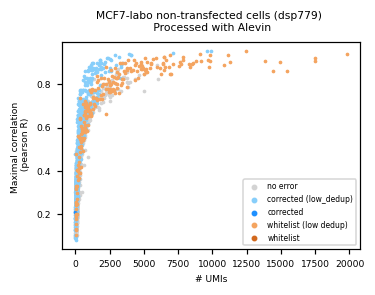

In [552]:
select = []

for barcode in sc.obs["CB"] :
    if barcode in errors_low_dedup :
        select.append("corrected (low_dedup)")
    elif barcode in originals_low_dedup :
        select.append("whitelist (low dedup)")
    elif barcode in errors_normal_dedup :
        select.append("corrected")
    elif barcode in originals_normal_dedup :
        select.append("whitelist")
    else :
        select.append("no error")

sc.obs["select"] = np.array(select, dtype=str)

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)

In [537]:
errors_dict["CCTTGTCGCGTG"]

['CCTTGTCGCGTC',
 'CCTTGTCGCGTA',
 'CCTTGTCGCGTT',
 'CCTTATCGCGTG',
 'CCTTGTCACGTG',
 'CCTTGTCGCATG',
 'CCTTGTCGCGGG',
 'GCTTGTCGCGTG']

In [536]:
errors_dict

{'CCTTGTCGCGTG': ['CCTTGTCGCGTC',
  'CCTTGTCGCGTA',
  'CCTTGTCGCGTT',
  'CCTTATCGCGTG',
  'CCTTGTCACGTG',
  'CCTTGTCGCATG',
  'CCTTGTCGCGGG',
  'GCTTGTCGCGTG'],
 'CCTTGTCGCGTC': ['CCTTGTCGCATC',
  'CCTTATCGCGTC',
  'CCTTGTCACGTC',
  'CCTTGTCGCGGC'],
 'CCTTGTCGCGTA': ['CCTTATCGCGTA',
  'CCTTGTCGCATA',
  'CCTTGTCACGTA',
  'CCTTGTCGCGGA'],
 'CCTTGTCGCGTT': ['CCTTGTCGCGGT',
  'CCTTGTCGCATT',
  'CCTTGTCACGTT',
  'CCTTATCGCGTT'],
 'CCGCGCTTGAGC': ['CCGCGCTTGCGC',
  'CCGCGCTTAAGC',
  'CCACGCTTGAGC',
  'CCGCACTTGAGC',
  'CCGCGCTTGAAC',
  'GCGCGCTTGAGC',
  'CCGCGCGTGAGC',
  'CCGCGCTAGAGC',
  'ACGCGCTTGAGC',
  'CCGCGCTTGAGA',
  'CCGCGCATGAGC',
  'CCGCGATTGAGC',
  'CTGCGCTTGAGC',
  'CCGCGCTTCAGC'],
 'ACGCGCTTGAGC': ['ATGCGCTTGAGC'],
 'ATGCGCTTGAGC': ['ATGCGCTTGACC'],
 'GACGCCAAGAAA': ['GCCGCCAAGAAA',
  'TACGCCAAGAAA',
  'GACACCAAGAAA',
  'AACGCCAAGAAA',
  'GACGCCAAAAAA',
  'CACGCCAAGAAA',
  'GACGCAAAGAAA',
  'GGCGCCAAGAAA',
  'GACCCCAAGAAA',
  'GACGCCAACAAA',
  'GACTCCAAGAAA',
  'GACGCCAAGAAC'],


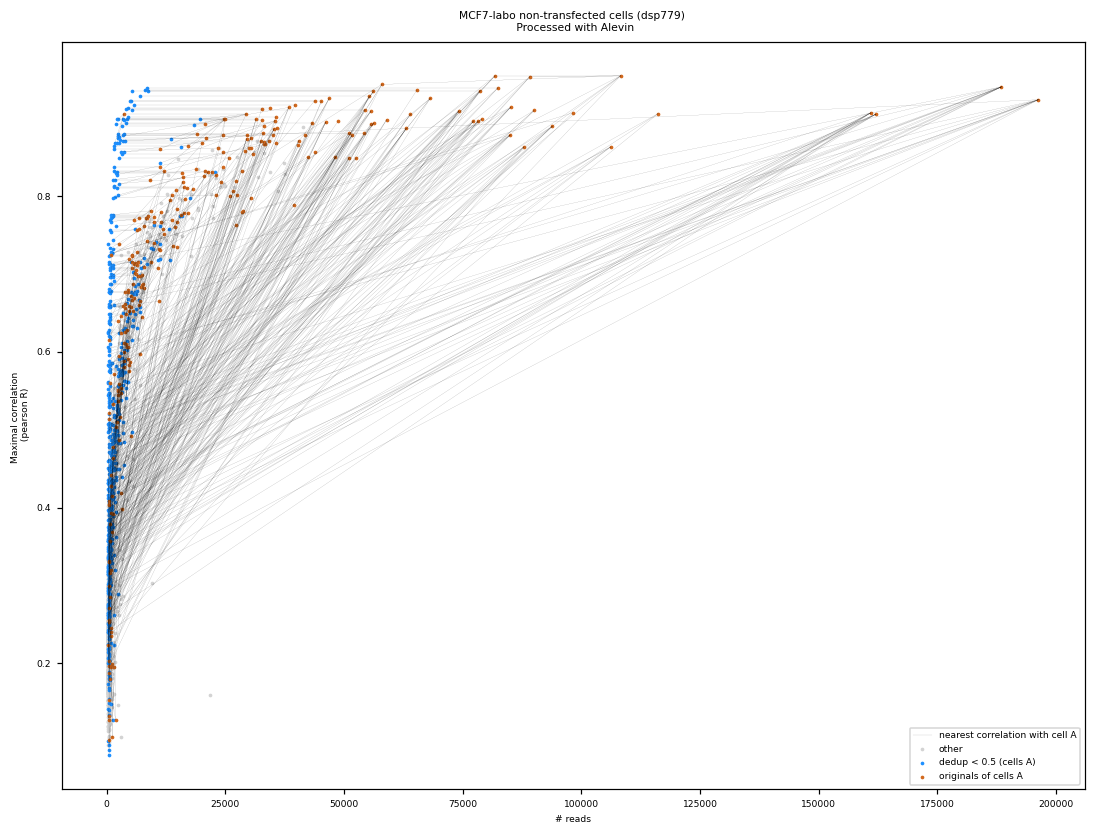

In [553]:
select = []


fig, _ = plt.subplots(figsize=(12,9))

i = 0
for barcode1 in sc.obs_names :
    if barcode1 in originals_low_dedup :
        select.append("originals of cells A")
        for barcode2 in errors_dict[barcode1] :
            x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.05, color = "black", label = "nearest correlation with cell A" if i == 0 else "")
            i += 1
    elif barcode1 in errors_low_dedup :
        select.append("dedup < 0.5 (cells A)")
    else :
        select.append("other")

sc.obs["select"] = np.array(select, dtype=str)
            
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"],\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"dedup < 0.5 (cells A)" : "dodgerblue", "originals of cells A" : "chocolate", "other" : "lightgray"},\
                        order_color = ["other", "dedup < 0.5 (cells A)","originals of cells A"], fig = fig)

plt.legend();

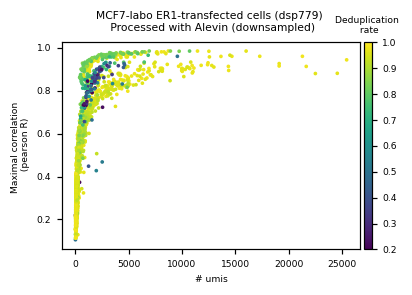

In [522]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# umis", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo ER1-transfected cells (dsp779) \n Processed with Alevin (downsampled)",\
                        color_title = "Deduplication \n rate", save = f"./figs/{cond}-reads-max-corr-downsampled.svg", vmax=1, vmin=0.2)

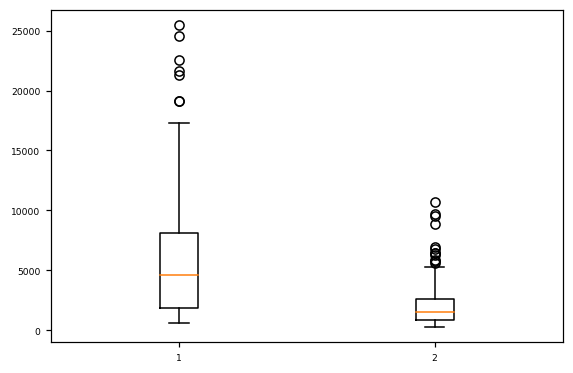

In [518]:
plt.boxplot([sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"], sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"]]);

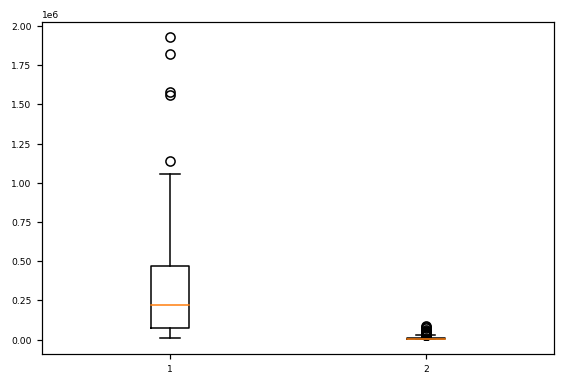

In [519]:
plt.boxplot([sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"], sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]]);

In [520]:
np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"])

1301534.0

In [521]:
np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"])

49890360

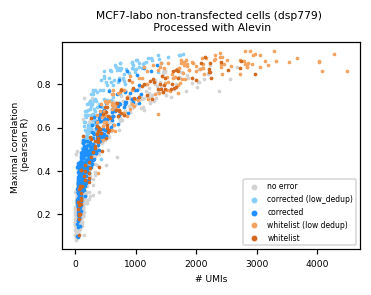

In [508]:
rnaseq.plotting.scatter(sc.obs["NumGenesExpressed"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)

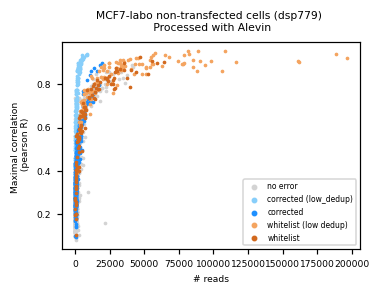

In [509]:
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)
# plt.xlim(0,160000)

In [1579]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2338 barcodes in the new whitelist


In [344]:
originals_low_dedup = []
errors_low_dedup = []
originals_mid_dedup = []
errors_mid_dedup = []
originals_normal_dedup = []
errors_normal_dedup = []
others = []

for barcode in sc.obs_names : 
    if barcode in whitelist and barcode not in errors_dict.keys() :
        others.append(barcode)
    elif barcode in whitelist and sc.obs["cluster_3"].loc[barcode] == '0' :
        originals_low_dedup.append(barcode)
    elif barcode in whitelist and sc.obs["cluster_3"].loc[barcode] == '1' :
        originals_mid_dedup.append(barcode)
    elif barcode in whitelist and sc.obs["cluster_3"].loc[barcode] == '2' :
        originals_normal_dedup.append(barcode)
    elif barcode not in whitelist and sc.obs["cluster_3"].loc[barcode] == '0' :
        errors_low_dedup.append(barcode)
    elif barcode not in whitelist and sc.obs["cluster_3"].loc[barcode] == '1' :
        errors_mid_dedup.append(barcode)
    elif barcode not in whitelist and sc.obs["cluster_3"].loc[barcode] == '2' :
        errors_normal_dedup.append(barcode)

In [1540]:
sc.obs["total_UMIs"].loc[errors_mid_dedup][-len(errors_low_dedup):].sum()

45364.0

In [817]:
# originals_low_dedup = []
# errors_low_dedup = []
# originals_normal_dedup = []
# errors_normal_dedup = []

# for original in errors_dict.keys():
#     for error in errors_dict[original] :
#         if sc.obs["DedupRate"][sc.obs["CB"] == error][0] < 0.2 :
#             originals_low_dedup.append(original)
#             errors_low_dedup.append(error)
#         else :
#             originals_normal_dedup.append(original)
#             errors_normal_dedup.append(error)
            

# no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])

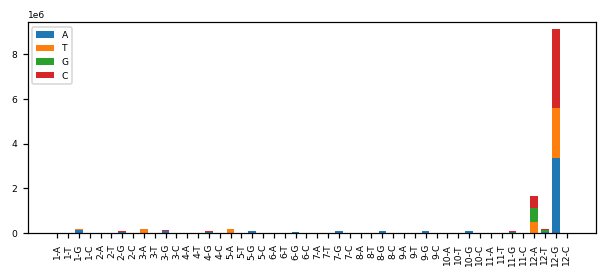

In [345]:
plot_errors(errors_dict, errors_normal_dedup)

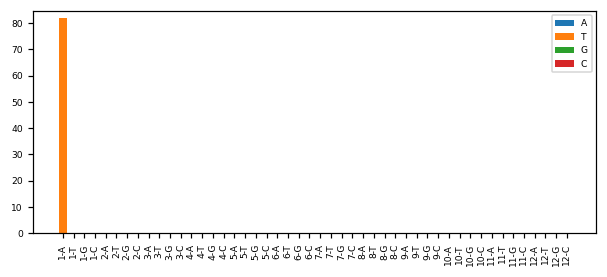

In [346]:
plot_errors(errors_dict, errors_mid_dedup, weight_by_lib=False);
# plt.ylim(0,50000)

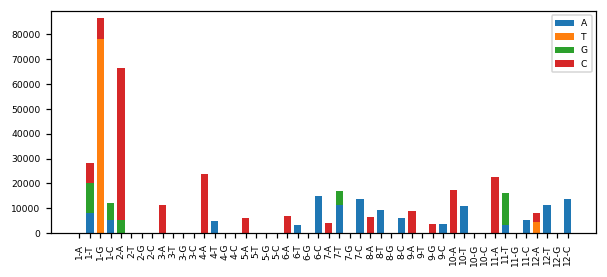

In [347]:
plot_errors(errors_dict, errors_low_dedup)

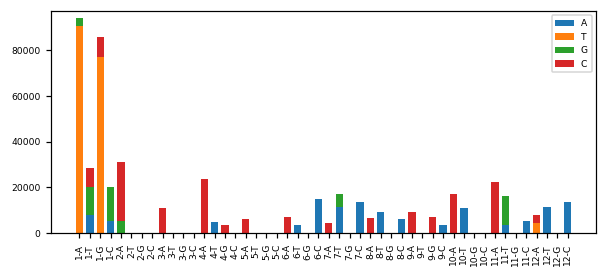

In [1544]:
plot_errors(errors_dict, np.setdiff1d(errors_low_dedup,['GCCGCCAAGAAA', 'TACGCCAAGAAA']))

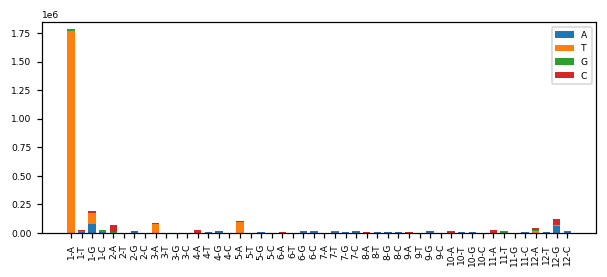

In [1547]:
plot_errors(errors_dict, np.concatenate([errors_mid_dedup,errors_low_dedup]))

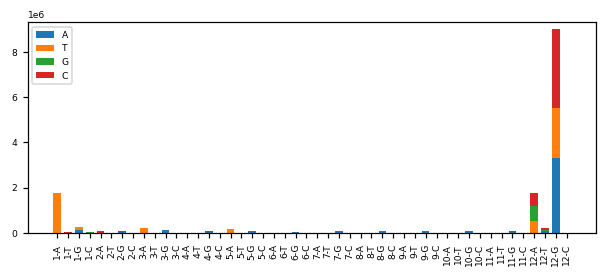

In [1548]:
plot_errors(errors_dict, sc.obs_names)

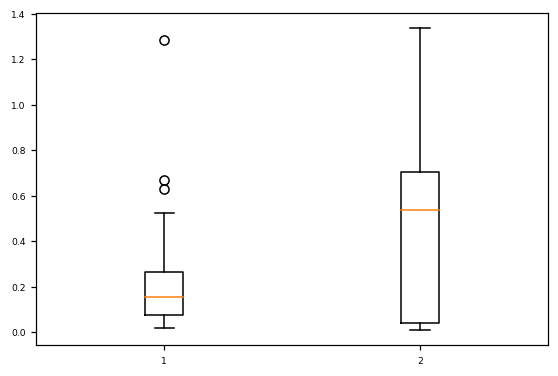

In [1569]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_low_dedup)[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_low_dedup)[0]].values

x2 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_mid_dedup)[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_mid_dedup)[0]].values

plt.boxplot([x1,x2]);

In [1567]:
x2

CB
AAACTCAGATGC   NaN
AAAGACCCGGAG   NaN
AAAGACCCGGAT   NaN
AACCCCTCATGA   NaN
AACCCCTTACCA   NaN
                ..
TTGTGTTCTCAA   NaN
TTTAGATCCAGG   NaN
TTTCTCCAGTCT   NaN
TTTCTGAAACGA   NaN
TTTGCTGAGTGG   NaN
Name: total_UMIs, Length: 326, dtype: float32

In [1561]:
get_intended_barcodes(errors_dict, errors_low_dedup)[1]

array(['CCTTGTCGCGGG', 'GCTTGTCGCGTG', 'CCGCGCTTGCGC', 'GCGCGCTTGAGC',
       'CCGCGCGTGAGC', 'CCGCGCTAGAGC', 'ACGCGCTTGAGC', 'CCGCGCTTGAGA',
       'CCGCGCATGAGC', 'CCGCGATTGAGC', 'CCGCGCTTCAGC', 'GCCGCCAAGAAA',
       'TACGCCAAGAAA', 'CACGCCAAGAAA', 'GACGCAAAGAAA', 'GGCGCCAAGAAA',
       'GACCCCAAGAAA', 'GACGCCAACAAA', 'GACGCCAAGAAC', 'CAGTGCCTATCT',
       'CAGAGACTATCT', 'CAGTGACTATCA', 'CAGTGAATATCT', 'GAGTGACTATCT',
       'CAGTGACAATCT', 'CAGTGACTAACT', 'CCCGAAGGATCA', 'CCCGAAGGCTCC',
       'CCCGAAGGATAC', 'CCCGAAGGAACC', 'AGTAATAGCTAG', 'AGTAAATGCTAG',
       'TGTGTCAAGAGC', 'GGTGTCAAGCGC', 'GCGGCGGAACAG', 'GACCCCCCTTCG',
       'GCCACCCCTTCG', 'GACACACCTTCG', 'TACACCCCTTCG', 'AGCCGAGCTTCG',
       'CAAAGCTACTTC', 'CAAAGCTCCATC', 'CAAAGCTCCTTA', 'CAAAGCTCATTC',
       'CAAAGCACCTTC', 'CAAAGCTCCTAC', 'GCGCGGGATGCC', 'TCGCGGGATGAC',
       'TCGCTTGTGTGC', 'TATTTTGAGCCG', 'GATTTTGCGCCG', 'ACACAGTCGACA',
       'AGTCGTGAGGTT', 'AGTCGTGAGGGA', 'TAGTACTCAGAG', 'TCGCATCGTGTC',
      

In [1475]:
np.argwhere(sc.obs["total_UMIs"].loc[errors_mid_dedup].values > sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_mid_dedup)].values)

array([[62]])

In [1476]:
sc.obs["DedupRate"][62]

0.9793379999999999

In [1478]:
np.max(sc.obs["DedupRate"].loc[errors_mid_dedup])

0.896381

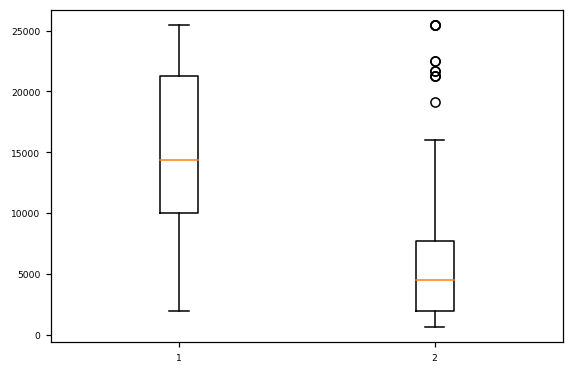

In [1471]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_low_dedup)]
x2 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, errors_mid_dedup)]
plt.boxplot([x1,x2]);

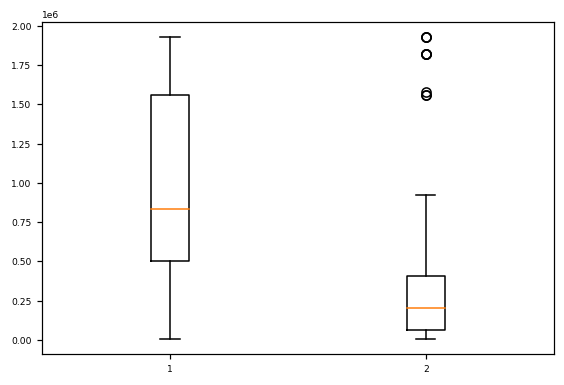

In [980]:
x1 = sc.obs["raw_cb_freq"].loc[get_intended_barcodes(errors_dict, errors_low_dedup)]
x2 = sc.obs["raw_cb_freq"].loc[get_intended_barcodes(errors_dict, errors_mid_dedup)]
plt.boxplot([x1,x2]);

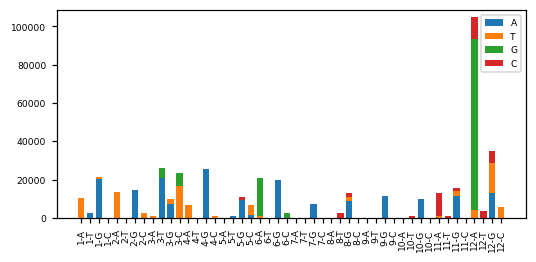

In [818]:
plot_errors(errors_dict, errors_normal_dedup)

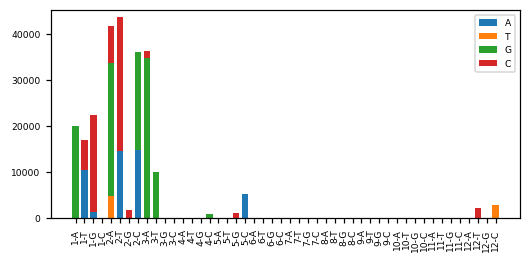

In [819]:
plot_errors(errors_dict, errors_low_dedup)

In [188]:
import pandas
import ast
sample = "Sample_N705_-_ER1"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")

In [189]:
total_scores = []

for barcode in sc.obs["CB"] :
#     phreds = np.concatenate([ast.literal_eval(chunk) for chunk in x[barcode].values])
    phreds = ast.literal_eval(x[barcode].values[0])[:10000]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [190]:
corrected_low_dedup_phreds = np.array(total_scores[[b in errors_low_dedup for b in sc.obs_names]])
corrected_mid_dedup_phreds = np.array(total_scores[[b in errors_mid_dedup for b in sc.obs_names]])
corrected_normal_dedup_phreds = np.array(total_scores[[b in errors_normal_dedup for b in sc.obs_names]])
random_phreds = np.array(total_scores[[b in whitelist for b in sc.obs_names]])

(20.0, 35.0)

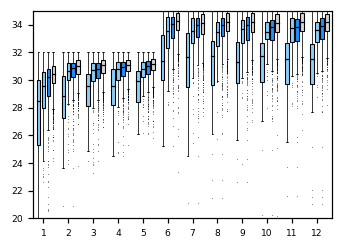

In [194]:
ax = plt.subplots(figsize=(3.5, 2.5))

flierprops = {'marker':'.', 'markersize':1, 'markeredgecolor':'none', 'markerfacecolor':'black'}
medianprops = {'color':'black', 'linewidth':0.8}
whiskerprops = {'linewidth': 0.5}
capprops = {'linewidth': 0.5}


bp = plt.boxplot(corrected_low_dedup_phreds, positions = np.arange(0,60,5), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(corrected_mid_dedup_phreds, positions = np.arange(1,60,5), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(corrected_normal_dedup_phreds, positions = np.arange(2,60,5), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(random_phreds, positions = np.arange(3,60,5), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

plt.xticks(np.arange(1,60,5), labels = np.arange(1,13))
plt.xlim(-1, 59);
plt.ylim(20,35)

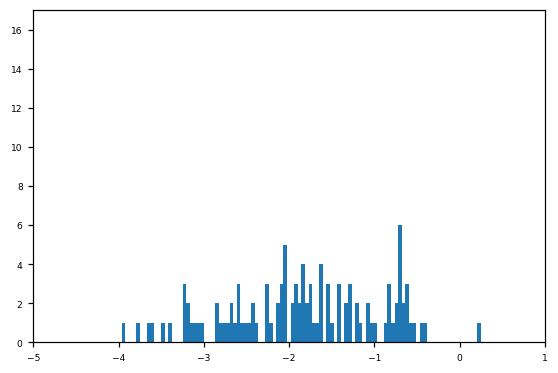

In [90]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='0'])[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='0'])[0]].values

plt.xlim(-5,1)
plt.ylim(0,17)
plt.hist(np.log(x1), bins = 100);

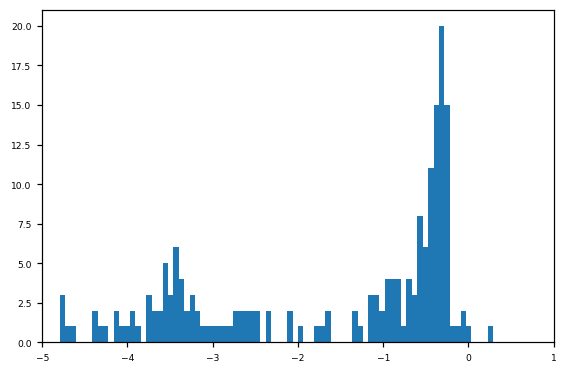

In [103]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='1'])[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='1'])[0]].values

plt.xlim(-5,1)
plt.ylim(0,21)
plt.hist(np.log(x1), bins = 80);

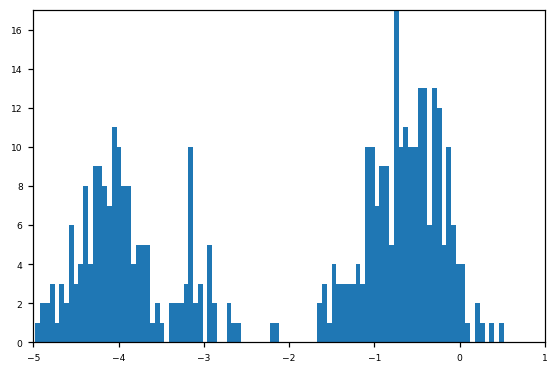

In [91]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='2'])[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, sc.obs_names[sc.obs["cluster_3"]=='2'])[0]].values

plt.xlim(-5,1)
plt.ylim(0,17)
plt.hist(np.log(x1), bins = 100);

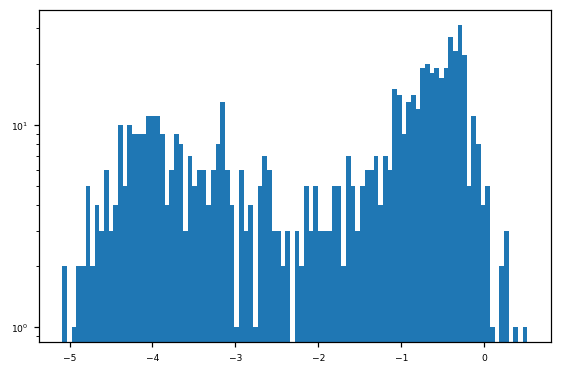

In [64]:
x1 = sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, np.concatenate(list(errors_dict.values())))[1]].values / \
sc.obs["total_UMIs"].loc[get_intended_barcodes(errors_dict, np.concatenate(list(errors_dict.values())))[0]].values
plt.yscale('log')


plt.hist(np.log(x1), bins = 100);

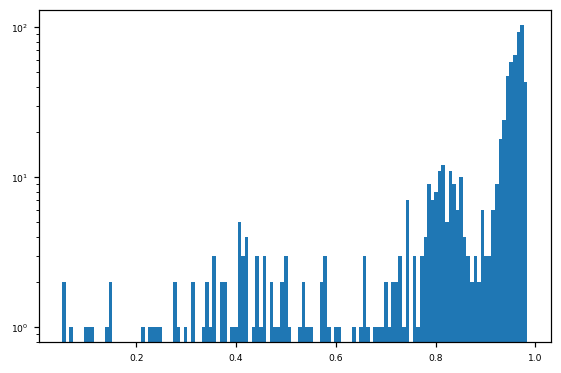

In [66]:
x2 = sc.obs["DedupRate"].loc[np.concatenate(list(errors_dict.values()))].values 
plt.yscale('log')
plt.hist(x2, bins = 130);

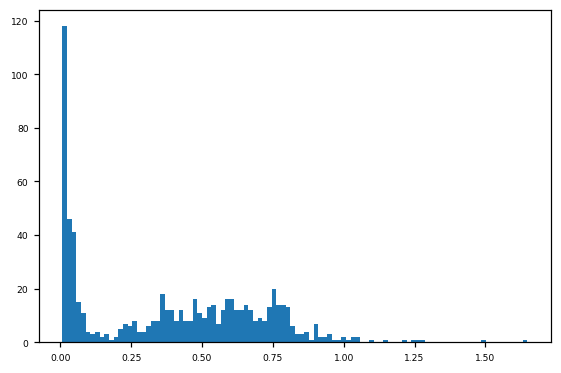

In [75]:
plt.hist(x1**x2, bins = 100);

In [113]:
len(errors_low_dedup)

98

In [117]:
len(np.unique(get_intended_barcodes(errors_dict, errors_low_dedup)[0]))

47

In [119]:
len(errors_mid_dedup)

191

In [118]:
len(np.unique(get_intended_barcodes(errors_dict, errors_mid_dedup)[0]))

122

In [121]:
len(errors_normal_dedup)

504

In [120]:
len(np.unique(get_intended_barcodes(errors_dict, errors_normal_dedup)[0]))

176

In [122]:
len(normal_dedup_shared_umis)

30

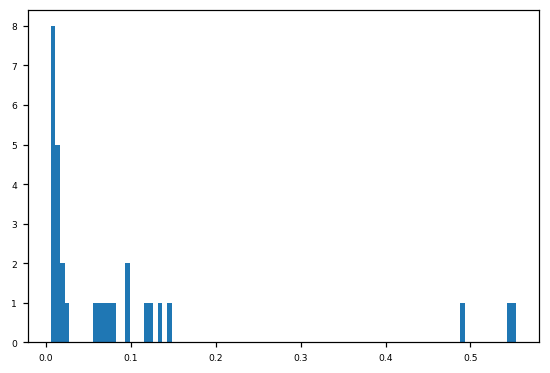

In [107]:
plt.hist(normal_dedup_shared_umis, bins = 100);

In [411]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2305 barcodes in the new whitelist


In [171]:
len(errors_dict.values())

227

In [174]:
len(errors_dict.values())



227

In [179]:
# gm = GaussianMixture(2)
gm = KMeans(3)
clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
#clusters_3 = gm.fit_predict(np.array([sc.obs["DedupRate"], sc.obs["max_corr"]]).T).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_3[clusters_3 == cl] = str(new_cl)

sc.obs["cluster_3"] = clusters_3

In [24]:
errors_low_dedup = []
errors_mid_dedup = []
errors_normal_dedup = []

for original in errors_dict.keys():
    for error in errors_dict[original] :
        if sc.obs["cluster_3"].loc[error] == '0':
            errors_low_dedup.append(error)
        if sc.obs["cluster_3"].loc[error] == '1':
            errors_mid_dedup.append(error)
        else :
            errors_normal_dedup.append(error)
            

no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])

In [437]:
import pandas
import ast
sample = "Sample_N705_-_ER1"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [439]:
low_dedup_shared_umis = []
mid_dedup_shared_umis = []
normal_dedup_shared_umis = []
random_shared_umis = []


for o,e in zip(get_intended_barcodes(errors_dict, errors_low_dedup)[0], get_intended_barcodes(errors_dict, errors_low_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_o) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    low_dedup_shared_umis.append(shared_umis/n_umis)

for o,e in zip(get_intended_barcodes(errors_dict, errors_mid_dedup)[0], get_intended_barcodes(errors_dict, errors_mid_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_o) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    mid_dedup_shared_umis.append(shared_umis/n_umis)
    
for o,e in zip(get_intended_barcodes(errors_dict, errors_normal_dedup)[0], get_intended_barcodes(errors_dict, errors_normal_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_o) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    normal_dedup_shared_umis.append(shared_umis/n_umis)
    
for i in range(len(errors_normal_dedup)):
    cb1,cb2 = np.random.choice(no_error, 2, replace = False)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_cb2) #+ len(umis_cb2)
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_shared_umis.append(shared_umis/n_umis)

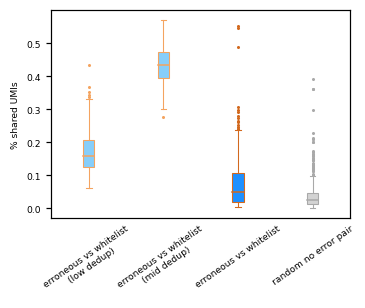

In [440]:
_, ax = plt.subplots(figsize=(3.5, 2.5))



bp = plt.boxplot(low_dedup_shared_umis, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})


bp = plt.boxplot(mid_dedup_shared_umis, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})

bp = plt.boxplot(normal_dedup_shared_umis, positions = [2], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(random_shared_umis, positions = [3], patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 capprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,4), labels = ["erroneous vs whitelist\n(low dedup)", "erroneous vs whitelist\n(mid dedup)", "erroneous vs whitelist", "random no error pair"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

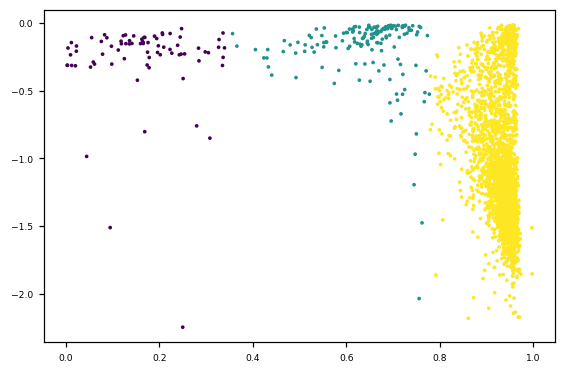

In [180]:
plt.scatter(sc.obs["DedupRate"]**2, np.log(sc.obs["max_corr"]), s = 2, c = sc.obs["cluster_3"].astype(int))

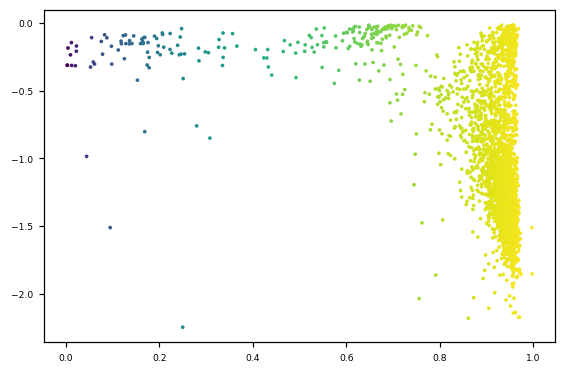

In [185]:
plt.scatter(sc.obs["DedupRate"]**2, np.log(sc.obs["max_corr"]), s = 2, c = sc.obs["DedupRate"])

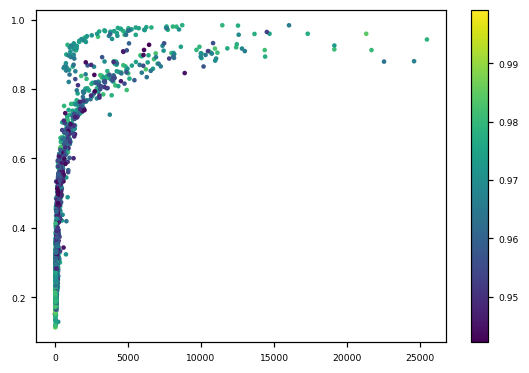

In [140]:
plt.scatter(sc.obs["total_UMIs"][sc.obs["cluster_3"]=="2"], sc.obs["max_corr"][sc.obs["cluster_3"]=="2"], s = 4, c = sc.obs["DedupRate"][sc.obs["cluster_3"]=="2"]);
plt.colorbar()

(0.0, 0.78)

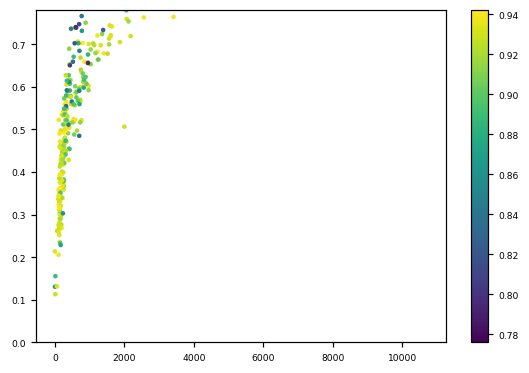

In [142]:
plt.scatter(sc.obs["total_UMIs"][sc.obs["cluster_3"]=="1"], sc.obs["max_corr"][sc.obs["cluster_3"]=="1"], s = 4, c = sc.obs["DedupRate"][sc.obs["cluster_3"]=="1"]);
plt.colorbar()
plt.ylim(0,0.78)

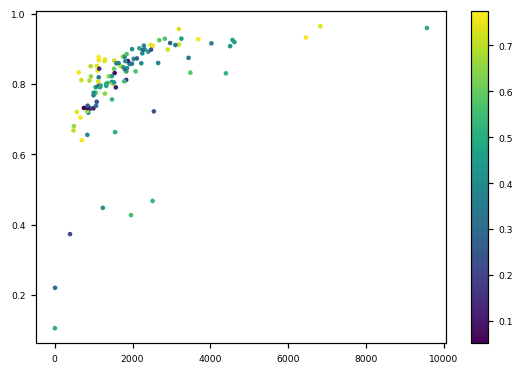

In [138]:
plt.scatter(sc.obs["total_UMIs"][sc.obs["cluster_3"]=="0"], sc.obs["max_corr"][sc.obs["cluster_3"]=="0"], s = 4, c = sc.obs["DedupRate"][sc.obs["cluster_3"]=="0"]);
plt.colorbar()

In [1467]:
tfrac = []
barcodes = np.concatenate([errors_normal_dedup, get_intended_barcodes(errors_dict, errors_normal_dedup)])
for cb in barcodes :
    umis = 0
    tumis=0
    for umi in ast.literal_eval(x[cb].values[0]) :
        umis+=1
        if umi[-1] == 'T':
            tumis+=1
    tfrac.append(tumis)

In [1468]:
tfrac_normal = []
for cb in np.setdiff1d(sc.obs_names, barcodes) :
    umis = 0
    tumis=0
    for umi in ast.literal_eval(x[cb].values[0]):
        umis+=1
        if umi is not None and umi[-1] == 'T':
            tumis+=1
    tfrac_normal.append(tumis)

In [748]:
np.setdiff1d(sc.obs_names, last_pos_err).shape

(2355,)

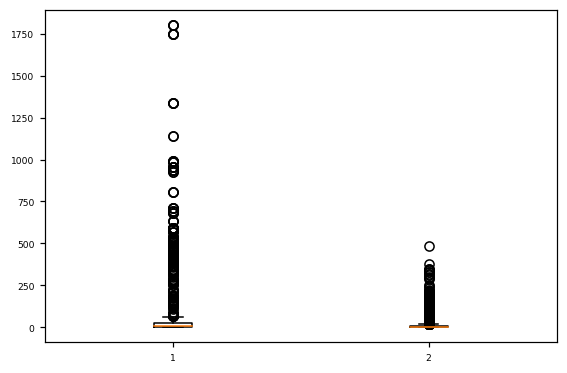

In [1469]:
plt.boxplot([tfrac, tfrac_normal]);

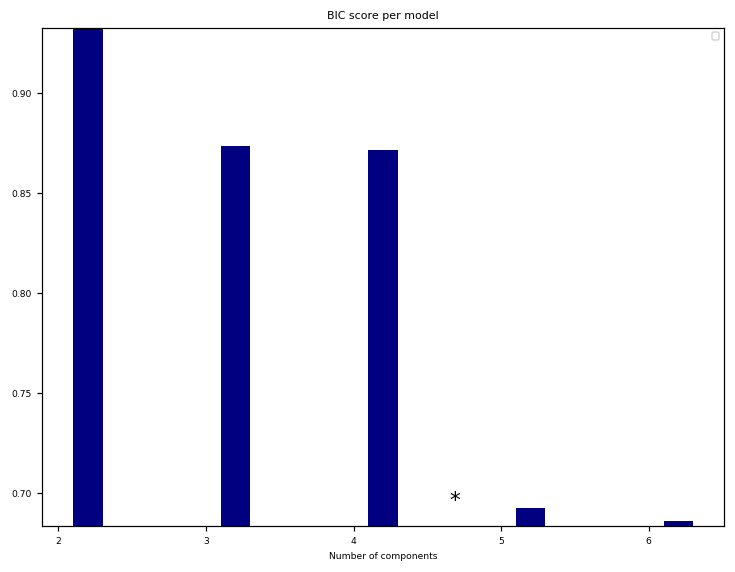

In [49]:
import numpy as np
import itertools
# from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Generate random sample, two components
# np.random.seed(0)
lowest_bic = -1
bic = []
n_components_range = range(2, 7)
for n_components in n_components_range:
    gmm = KMeans(n_components)
    cl = gmm.fit_predict(sc.obs["DedupRate"].values.reshape(-1,1))
    bic.append(silhouette_score(sc.obs["DedupRate"].values.reshape(-1, 1), cl))
    if bic[-1] > lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy'])
clf = best_gmm
bars = []

# Plot the BIC scores
fig, spl = plt.subplots(figsize=(8, 6))
xpos = np.array(n_components_range) + .2 * (i - 2)
plt.bar(xpos, bic, width=.2, color='navy')
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


In [87]:
%%bash
tar czf ./figs.tar.gz ./figs/*.svg